# Veri Madenciliğinde İleri Konular Projesi

**Veri Seti:** İlaçlar ve Yan Etkileri (real_drug_dataset.csv)

Hazırlayan: Mustafa Engin Dalgıç

Öğrenci No: 254309502

Program: Bilgisayar Mühendisliği Tezli Yüksek Lisans Programı

Kurum: Üsküdar Üniversitesi, Fen Bilimleri Enstitüsü

E-posta: engindalgic86@gmail.com

Bu projede, ilaçlar ve yan etkileri içeren veri seti üzerinde kapsamlı dokuz aşamalı bir veri madenciliği analizi gerçekleştirlmiştir. 
Program Çıktılar: Proje raporu(html), 9 görsel(png),1 html çıktısı

## Gerekli Kütüphanelerin İçe Aktarılması

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Pandas görüntüleme ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Kütüphaneler başarıyla yüklendi!")

Kütüphaneler başarıyla yüklendi!


## Google Colab - Lokal Otomatik Veri Seti Yükleme

**Google Colab kullanımı için veri seti:** Veri seti otomatik olarak GitHub'dan indirilecek. https://github.com/engindalgic86-cpu/UU_VMIK_DRUGS?tab=readme-ov-file

**Lokal kullanım:** `real_drug_dataset.csv` dosyasını aynı dizinde bulunmaktadır.

In [ ]:
# ============================================================================
# KAGGLE VERİ SETİ OTOMATİK İNDİRME
# ============================================================================
# Bu hücre veri setini Kaggle'dan otomatik olarak indircektir
# 3 farklı yöntem dener: Kaggle API, opendatasets, manuel talimat
# ============================================================================

import os
import sys

# Veri seti bilgileri
KAGGLE_DATASET = "palakjain9/1000-drugs-and-side-effects"
TARGET_FILE = "real_drug_dataset.csv"

print("="*70)
print("VERİ SETİ KONTROL VE İNDİRME")
print("="*70)

# Veri seti zaten var mı?
if os.path.exists(TARGET_FILE):
    file_size = os.path.getsize(TARGET_FILE) / 1024
    print(f"\n Veri seti bulundu!")
    print(f"    Dosya: {TARGET_FILE}")
    print(f"    Boyut: {file_size:.1f} KB")
    print("\n" + "="*70)
    print("Veri seti hazır, analiz devam edebiliriz.")
    print("="*70)
else:
    print(f"\n Veri seti bulunamadı: {TARGET_FILE}")
    print("\n Otomatik indirme başlatılıyor...\n")
    
    # YÖNTEM 1: Kaggle API ile dene
    try:
        print("-"*70)
        print("YÖNTEM 1: Kaggle API")
        print("-"*70)
        
        try:
            from kaggle.api.kaggle_api_extended import KaggleApi
        except ImportError:
            print(" kaggle paketi yükleniyor...")
            import subprocess
            subprocess.check_call([sys.executable, "-m", "pip", "install", "kaggle", "-q"])
            from kaggle.api.kaggle_api_extended import KaggleApi
        
        api = KaggleApi()
        api.authenticate()
        
        print(f" İndiriliyor: {KAGGLE_DATASET}")
        api.dataset_download_files(KAGGLE_DATASET, path='.', unzip=True)
        
        # İndirilen CSV'yi bul ve yeniden adlandır
        import glob
        csv_files = [f for f in glob.glob('*.csv') if 'real_drug' in f.lower() or 'drug' in f.lower()]
        
        if csv_files:
            if csv_files[0] != TARGET_FILE:
                os.rename(csv_files[0], TARGET_FILE)
            print(f" İndirme başarılı! (Kaggle API)")
        
    except Exception as e1:
        print(f" Kaggle API başarısız: {str(e1)[:100]}")
        
        # YÖNTEM 2: opendatasets ile dene
        try:
            print("\n" + "-"*70)
            print("YÖNTEM 2: opendatasets (interaktif)")
            print("-"*70)
            print(" Kaggle kullanıcı adı ve API key girilmesi gerekecek")
            print("   (Hesabınız yoksa Ctrl+C ile iptal edin)\n")
            
            try:
                import opendatasets as od
            except ImportError:
                print(" opendatasets yükleniyor...")
                import subprocess
                subprocess.check_call([sys.executable, "-m", "pip", "install", "opendatasets", "-q"])
                import opendatasets as od
            
            dataset_url = f"https://www.kaggle.com/datasets/{KAGGLE_DATASET}"
            od.download(dataset_url)
            
            # İndirilen klasörden CSV'yi bul
            import shutil
            dataset_folder = KAGGLE_DATASET.split('/')[-1]
            csv_files = glob.glob(f"{dataset_folder}/*.csv")
            
            if csv_files:
                shutil.copy(csv_files[0], TARGET_FILE)
                print(f" İndirme başarılı! (opendatasets)")
                
        except KeyboardInterrupt:
            print("\n Kullanıcı tarafından iptal edildi")
            raise
        except Exception as e2:
            print(f" opendatasets başarısız: {str(e2)[:100]}")
            raise
    
    # Son kontrol
    if os.path.exists(TARGET_FILE):
        file_size = os.path.getsize(TARGET_FILE) / 1024
        print("\n" + "="*70)
        print(" VERİ SETİ HAZIRDIR")
        print("="*70)
        print(f" Dosya: {TARGET_FILE}")
        print(f" Boyut: {file_size:.1f} KB")
        print("="*70)
    else:
        print("\n" + "="*70)
        print(" OTOMATİK İNDİRME BAŞARISIZ - MANUEL İNDİRME GEREKLİ")
        print("="*70)
        print("""\nLütfen şu adımları izleyin:

1. https://www.kaggle.com/datasets/palakjain9/1000-drugs-and-side-effects
   adresine gidin

2. Kaggle hesabı oluşturun (ücretsiz)

3. 'Download' butonuna tıklayın

4. ZIP dosyasını açın, CSV dosyasını bulun

5. Dosyayı 'real_drug_dataset.csv' adıyla buraya yükleyin:
   - Google Colab: Sol menü →  Dosyalar → Upload
   - Lokal Jupyter: Bu notebook ile aynı klasöre kopyalayın

6. Bu hücreyi tekrar çalıştırın
        """)
        print("="*70)
        
        # Kullanıcıya seçenek sun
        print("\n ALTERNATİF: kaggle_data_downloader.py scriptini çalıştırın")
        print("   Terminal: python kaggle_data_downloader.py")

print("\n" + "="*70)


VERİ SETİ KONTROL VE İNDİRME

 Veri seti bulundu!
    Dosya: real_drug_dataset.csv
    Boyut: 57.5 KB

Veri seti hazır, analiz devam edebiliriz.



In [ ]:
# Google Colab'da mı çalışıyoruz kontrol et
try:
    import google.colab
    IN_COLAB = True
    print(" Google Colab ortamı tespit edildi!")
except:
    IN_COLAB = False
    print(" Lokal ortamda çalışıyorsunuz")

if IN_COLAB:
    import os
    
    # Veri seti zaten var mı kontrol et
    if os.path.exists('real_drug_dataset.csv'):
        print(" Veri seti zaten mevcut!")
    else:
        print(" Veri seti GitHub'dan indiriliyor...")
        print("   Repository: engindalgiC86-cpu/UU_VMIK_DRUGS")
        
        # GitHub'dan veri setini indir
        !wget -q https://raw.githubusercontent.com/engindalgiC86-cpu/UU_VMIK_DRUGS/main/real_drug_dataset.csv
        
        # İndirme başarılı mı kontrol et
        if os.path.exists('real_drug_dataset.csv'):
            file_size = os.path.getsize('real_drug_dataset.csv')
            print(f"    Veri seti başarıyla indirildi! ({file_size:,} bytes)")
        else:
            print("    HATA: Veri seti indirilemedi!")
            print("\n Manuel yükleme adımları:")
            print("   1. Sol menüden  Dosyalar sekmesini açın")
            print("   2. Upload butonuna tıklayın")
            print("   3. 'real_drug_dataset.csv' dosyasını yükleyin")
            raise FileNotFoundError("Veri seti bulunamadı!")
else:
    # Lokal ortam - dosya kontrolü
    import os
    if os.path.exists('real_drug_dataset.csv'):
        print(" Veri seti bulundu!")
    else:
        print(" UYARI: 'real_drug_dataset.csv' bulunamadı!")
        print("   Lütfen veri setini bu dizine yerleştirin.")

print("\n" + "="*70)
print(" Kurulum tamamlandı! Veri yükleme işlemine geçebilirsiniz.")
print("="*70)

 Lokal ortamda çalışıyorsunuz
 Veri seti bulundu!

 Kurulum tamamlandı! Veri yükleme işlemine geçebilirsiniz.


## Veri Setinin Yüklenmesi

In [ ]:
# Veri setini yükleme
df = pd.read_csv('real_drug_dataset.csv')

print(f"Veri seti boyutu: {df.shape}")
print(f"\nSatır sayısı: {df.shape[0]}")
print(f"Sütun sayısı: {df.shape[1]}")
print("\nİlk 5 satır:")
df.head()

Veri seti boyutu: (1000, 9)

Satır sayısı: 1000
Sütun sayısı: 9

İlk 5 satır:


,Patient_ID,Age,Gender,Condition,Drug_Name,Dosage_mg,Treatment_Duration_days,Side_Effects,Improvement_Score
0,P0001,56,Male,Infection,Ciprofloxacin,50,9,Nausea,8.5
1,P0002,69,Male,Hypertension,Metoprolol,500,24,Tiredness,8.7
2,P0003,46,Female,Depression,Bupropion,100,25,Dry mouth,5.4
3,P0004,32,Male,Diabetes,Glipizide,850,44,Low blood sugar,6.4
4,P0005,60,Male,Depression,Bupropion,850,35,Anxiety,5.3


In [ ]:
# Veri seti hakkında genel bilgi
print("Veri Seti Bilgileri:")
print("="*50)
df.info()

print("\nEksik Değerler:")
print("="*50)
print(df.isnull().sum())

print("\nSütun İsimleri:")
print("="*50)
print(df.columns.tolist())

Veri Seti Bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               1000 non-null   object 
 1   Age                      1000 non-null   int64  
 2   Gender                   1000 non-null   object 
 3   Condition                1000 non-null   object 
 4   Drug_Name                1000 non-null   object 
 5   Dosage_mg                1000 non-null   int64  
 6   Treatment_Duration_days  1000 non-null   int64  
 7   Side_Effects             1000 non-null   object 
 8   Improvement_Score        1000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB

Eksik Değerler:
Patient_ID                 0
Age                        0
Gender                     0
Condition                  0
Drug_Name                  0
Dosage_mg                  0
Treatment_Duration_days   

---
## 1. Temel İstatistikler

Tüm sayısal sütunlar için temel istatistikleri hesaplanması: mean (ortalama), std (standart sapma), min (minimum), %25 (1. çeyrek), median (medyan), %75 (3. çeyrek) ve max (maksimum).

In [ ]:
# Sayısal sütunları belirleme
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

print("Sayısal Sütunlar:")
print(numerical_columns)
print("\n" + "="*80)

# Temel istatistikleri hesaplama
stats_df = df[numerical_columns].describe().T
stats_df = stats_df[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
stats_df.columns = ['Ortalama', 'Std Sapma', 'Minimum', '%25', 'Medyan', '%75', 'Maksimum']

print("Sayısal Sütunlar İçin Temel İstatistikler:")
print("="*80)
stats_df.round(2)

Sayısal Sütunlar:
['Age', 'Dosage_mg', 'Treatment_Duration_days', 'Improvement_Score']

Sayısal Sütunlar İçin Temel İstatistikler:


,Ortalama,Std Sapma,Minimum,%25,Medyan,%75,Maksimum
Age,49.86,18.11,18.0,35.0,50.0,66.0,79.0
Dosage_mg,352.65,295.42,50.0,100.0,250.0,500.0,850.0
Treatment_Duration_days,32.38,15.70,5.0,19.0,32.0,46.0,59.0
Improvement_Score,7.02,1.43,2.5,6.1,7.0,8.0,10.0


### İstatistiklerin Yorumum

Yukarıdaki tabloda her sayısal değişken için:
- **Ortalama:** Verilerin merkezi eğilimi
- **Std Sapma:** Verilerin yayılımı (düşük değer = veriler ortalamaya yakın)
- **Minimum ve Maksimum:** Değer aralığı
- **%25, Medyan, %75:** Verilerin dağılımı hakkında bilgi verir

Medyan ile ortalama arasındaki fark, verilerin çarpıklığını gösterecektir.

---
## 2. Kategorik Sütunların Görselleştirilmesi

Kategorik sütunlardaki verileri her sütun için ayrı pasta grafikleri ile gösterilmektedir.

In [ ]:
# Kategorik sütunları belirleme
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print("Kategorik Sütunlar:")
print(categorical_columns)
print(f"\nToplam {len(categorical_columns)} kategorik sütun bulundu.")

Kategorik Sütunlar:
['Patient_ID', 'Gender', 'Condition', 'Drug_Name', 'Side_Effects']

Toplam 5 kategorik sütun bulundu.


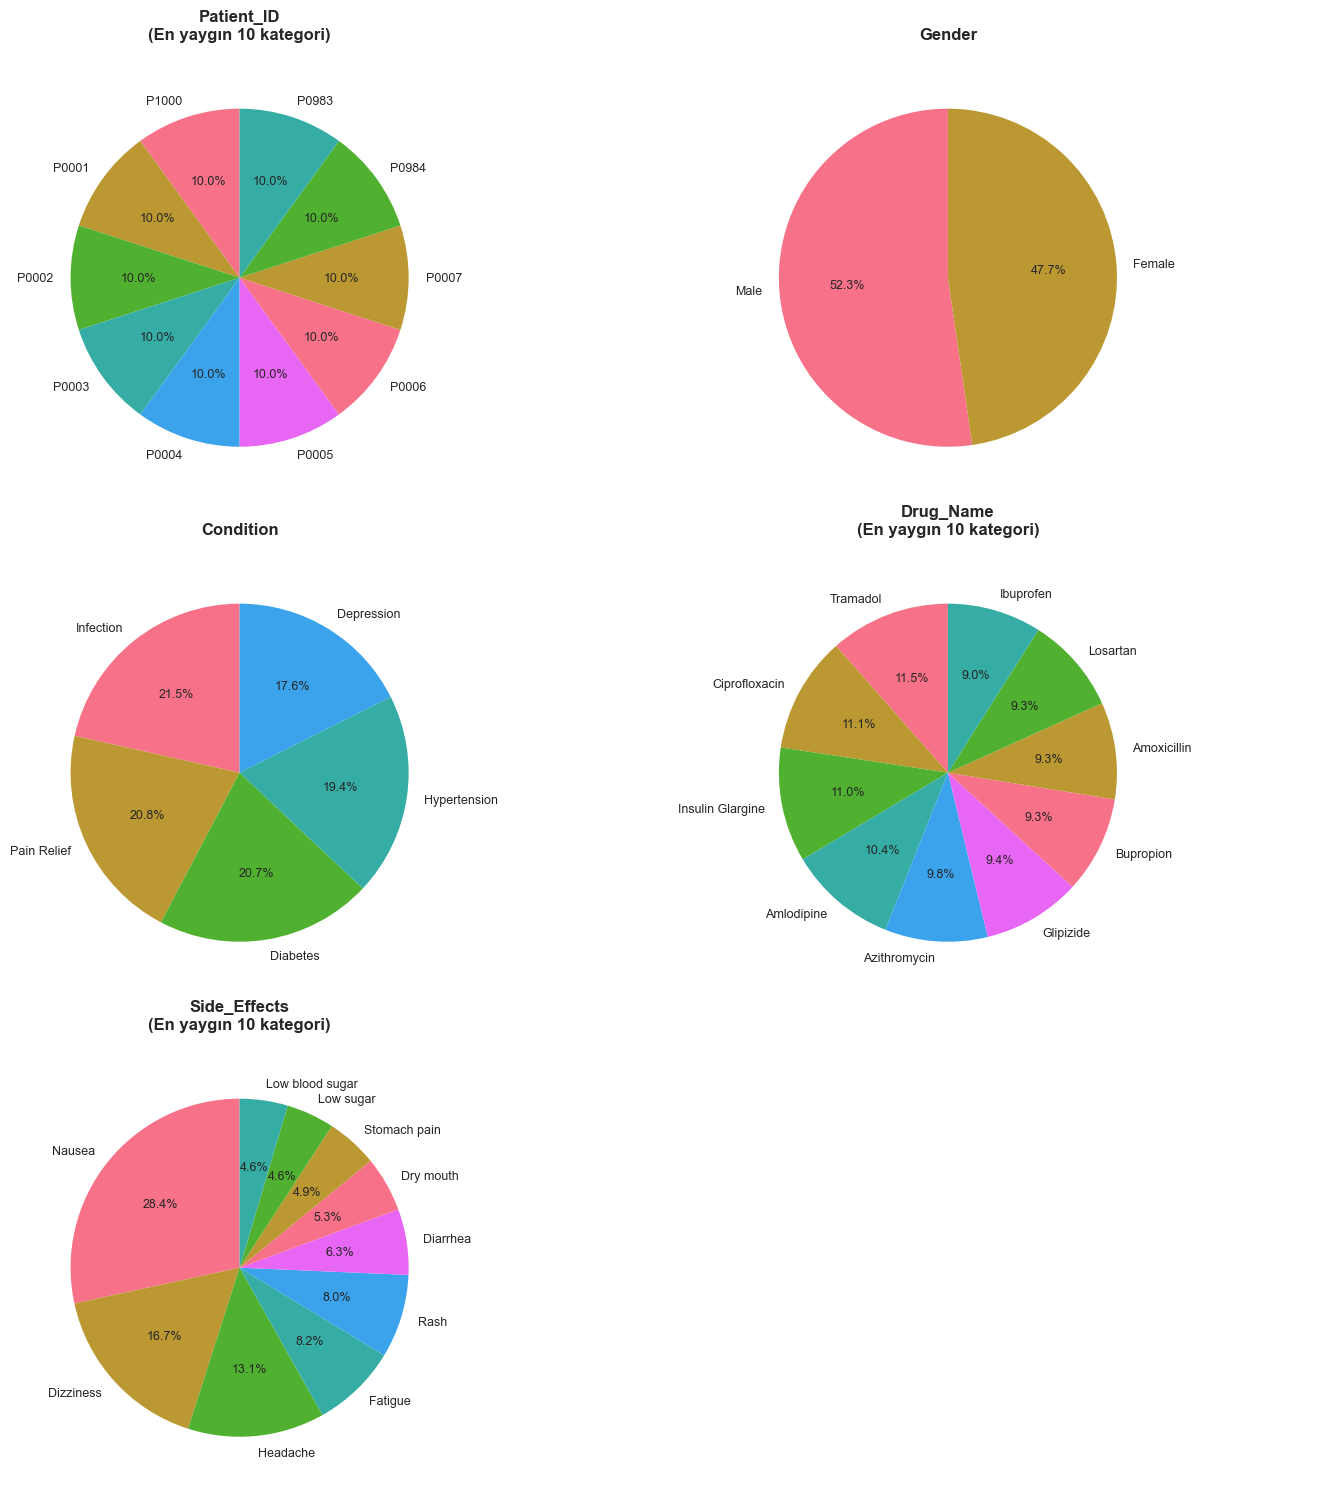

Pasta grafikleri başarıyla oluşturuldu


In [ ]:
# Her kategorik sütun için pasta grafiği çizme
n_cols = 2  # Her satırda 2 grafik
n_rows = (len(categorical_columns) + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if len(categorical_columns) > 1 else [axes]

for idx, col in enumerate(categorical_columns):
    # Her kategorinin sayısını hesaplama
    value_counts = df[col].value_counts()
    
    # Eğer çok fazla kategori varsa (>10), en yaygın 10'unu al
    if len(value_counts) > 10:
        value_counts = value_counts.head(10)
        title = f'{col}\n(En yaygın 10 kategori)'
    else:
        title = col
    
    # Pasta grafiği çizme
    axes[idx].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%',
                  startangle=90, textprops={'fontsize': 9})
    axes[idx].set_title(title, fontsize=12, fontweight='bold', pad=20)

# Kullanılmayan eksenleri gizleme
for idx in range(len(categorical_columns), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('kategorik_sutunlar_pasta_grafikleri.png', dpi=300, bbox_inches='tight')
plt.show()

print("Pasta grafikleri başarıyla oluşturuldu")

Buradaki pasta grafiği verilerini istatistiksel anlamda kategorik verilerin nominal veya ordinal ölçüm düzeyindeki dağılımını anlamak için kullananabilir.
Aynı zamanda Balance Check yapmamıza olanak sağlar. bu istatistiklere göre verilerin dengeli dağıldığını, kadın erkek oranın birbirine yakın olduğunu söyleyebliriz.

### Kategorik Değişkenlerin Detaylı İstatistikleri

In [ ]:
# Her kategorik sütun için frekans tablosu
for col in categorical_columns:
    print(f"\n{'='*60}")
    print(f"{col} - Frekans Dağılımı")
    print('='*60)
    
    freq_table = df[col].value_counts()
    freq_df = pd.DataFrame({
        'Kategori': freq_table.index,
        'Frekans': freq_table.values,
        'Yüzde': (freq_table.values / len(df) * 100).round(2)
    })
    
    if len(freq_df) > 15:
        print(freq_df.head(15))
        print(f"\n... ve {len(freq_df) - 15} kategori daha")
    else:
        print(freq_df)
    
    print(f"\nBenzersiz kategori sayısı: {df[col].nunique()}")


Patient_ID - Frekans Dağılımı
   Kategori  Frekans  Yüzde
0     P1000        1    0.1
1     P0001        1    0.1
2     P0002        1    0.1
3     P0003        1    0.1
4     P0004        1    0.1
5     P0005        1    0.1
6     P0006        1    0.1
7     P0007        1    0.1
8     P0984        1    0.1
9     P0983        1    0.1
10    P0982        1    0.1
11    P0981        1    0.1
12    P0980        1    0.1
13    P0979        1    0.1
14    P0978        1    0.1

... ve 985 kategori daha

Benzersiz kategori sayısı: 1000

Gender - Frekans Dağılımı
  Kategori  Frekans  Yüzde
0     Male      523   52.3
1   Female      477   47.7

Benzersiz kategori sayısı: 2

Condition - Frekans Dağılımı
       Kategori  Frekans  Yüzde
0     Infection      215   21.5
1   Pain Relief      208   20.8
2      Diabetes      207   20.7
3  Hypertension      194   19.4
4    Depression      176   17.6

Benzersiz kategori sayısı: 5

Drug_Name - Frekans Dağılımı
            Kategori  Frekans  Yüzde
0    

---
## 3. Hastalık Sebepleri ve Tedavi Süresi Dağılımı

Condition (hastalık) sütunundaki sebeplere karşılık gelen tedavi süresi (Treatment_Duration_days) dağılımını boxplot ile görselleştirelim.

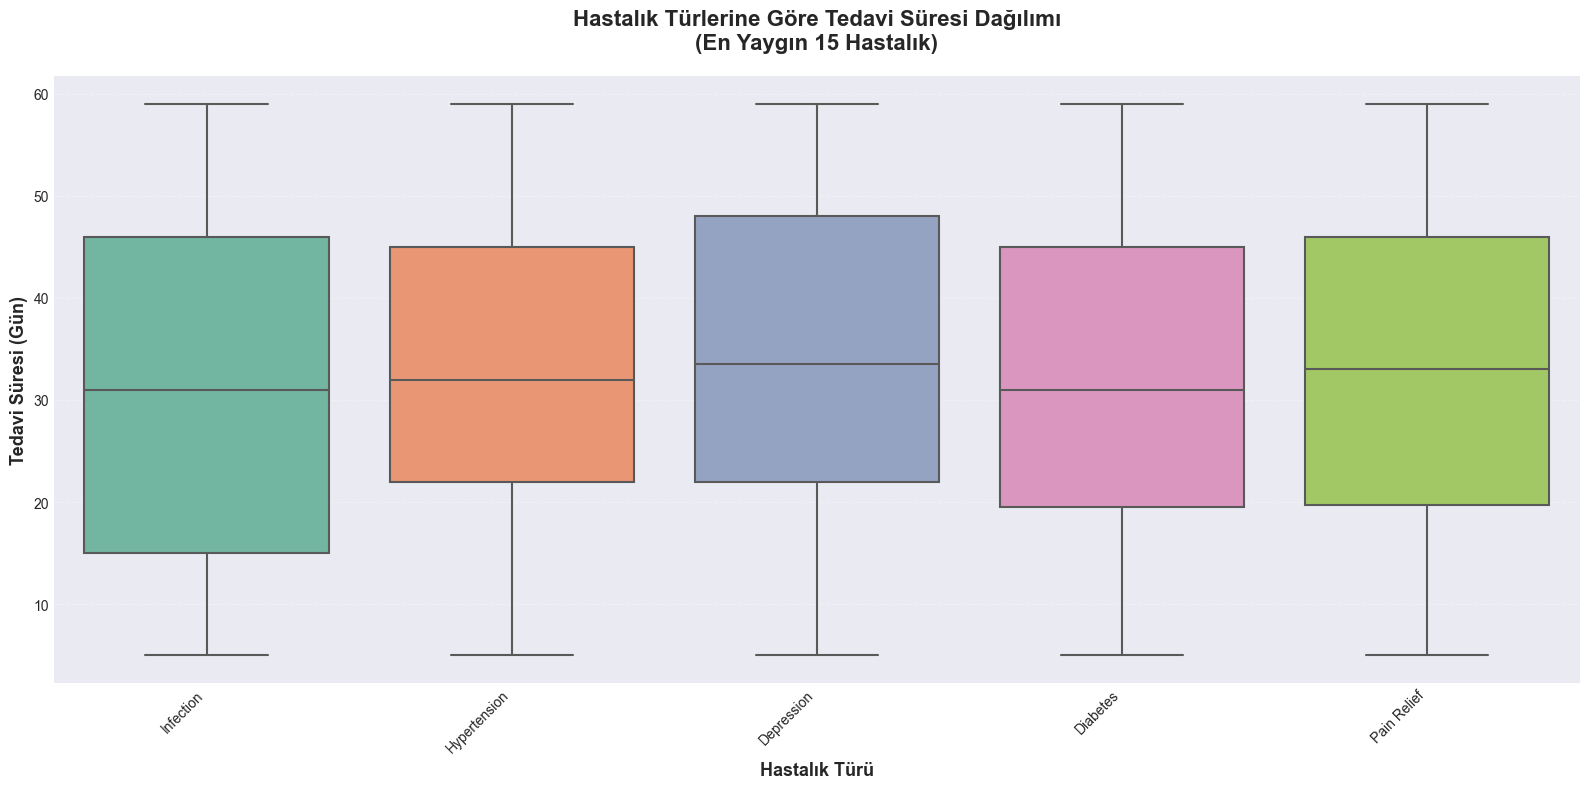


Hastalık Türlerine Göre Tedavi Süresi İstatistikleri:
              Ortalama  Medyan  Std Sapma  Min  Max  Vaka Sayısı
Condition                                                       
Depression       34.15    33.5      15.36    5   59          176
Hypertension     32.43    32.0      15.25    5   59          194
Pain Relief      32.41    33.0      15.62    5   59          208
Diabetes         32.23    31.0      15.38    5   59          207
Infection        31.00    31.0      16.71    5   59          215


In [ ]:
# Condition ve Treatment_Duration_days sütunlarının varlığını kontrol et
if 'Condition' in df.columns and 'Treatment_Duration_days' in df.columns:
    
    # En yaygın 15 hastalığı seç (görselleştirmeyi daha okunabilir yapmak için)
    top_conditions = df['Condition'].value_counts().head(15).index
    df_filtered = df[df['Condition'].isin(top_conditions)]
    
    # Boxplot oluşturma
    plt.figure(figsize=(16, 8))
    
    # Seaborn boxplot
    sns.boxplot(data=df_filtered, x='Condition', y='Treatment_Duration_days', 
                palette='Set2', linewidth=1.5)
    
    plt.title('Hastalık Türlerine Göre Tedavi Süresi Dağılımı\n(En Yaygın 15 Hastalık)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Hastalık Türü', fontsize=13, fontweight='bold')
    plt.ylabel('Tedavi Süresi (Gün)', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('hastalik_tedavi_suresi_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # İstatistiksel özet
    print("\nHastalık Türlerine Göre Tedavi Süresi İstatistikleri:")
    print("="*80)
    summary_stats = df_filtered.groupby('Condition')['Treatment_Duration_days'].agg([
        ('Ortalama', 'mean'),
        ('Medyan', 'median'),
        ('Std Sapma', 'std'),
        ('Min', 'min'),
        ('Max', 'max'),
        ('Vaka Sayısı', 'count')
    ]).round(2).sort_values('Ortalama', ascending=False)
    
    print(summary_stats)
    
else:
    print("Uyarı: 'Condition' veya 'Treatment_Duration_days' sütunu bulunamadı.")
    print("Mevcut sütunlar:", df.columns.tolist())

### Boxplot Yorumum

**Boxplot Elemanları:**
- **Kutu:** Verilerin %50'sini içerir (1. ve 3. çeyrek arası)
- **Ortadaki çizgi:** Medyan (ortanca değer)
- **Whiskers:** Minimum ve maksimum değerler (aykırı değerler hariç)
- **Noktalar:** Aykırı değerler (outliers)

**Gözlemlerim:**
- Farklı hastalıklar için tedavi sürelerinin nasıl değiştiğini görebiliriz.
- Bazı hastalıkların daha uzun ve değişken tedavi süreleri olabilir.Bu verilere bakarak hastaların yarısından fazlası oldukça yüksek iyileşme skorları olduğunu söyleyebiliriz.
- Aykırı değerler, normal olmayan uzun veya kısa tedavi sürelerini gösterir. Alt uçta, düşük puanlarda, bazı hastaların kullanılan ilaçlara hiç yanıt vermediğini söyleyebiliriz.
**Yorumum** 
- Bu aykırı değerlerin, veri madenciliği modellemesi (regresyon) için öneml olduğu, hastaların neden düşük skor aldığının incelenmesi gerekiğtini, inceleme sonrası modelin doğruluğunu artırabileceğini düşünmekteyim.

---
## 4. İlaç İsimleri ve Yan Etkiler - 2D Histogram

Drug_Name ve Side_Effects sütunları için 2 boyutlu histogram (2D frekans görselleştirmesi) çizimi.

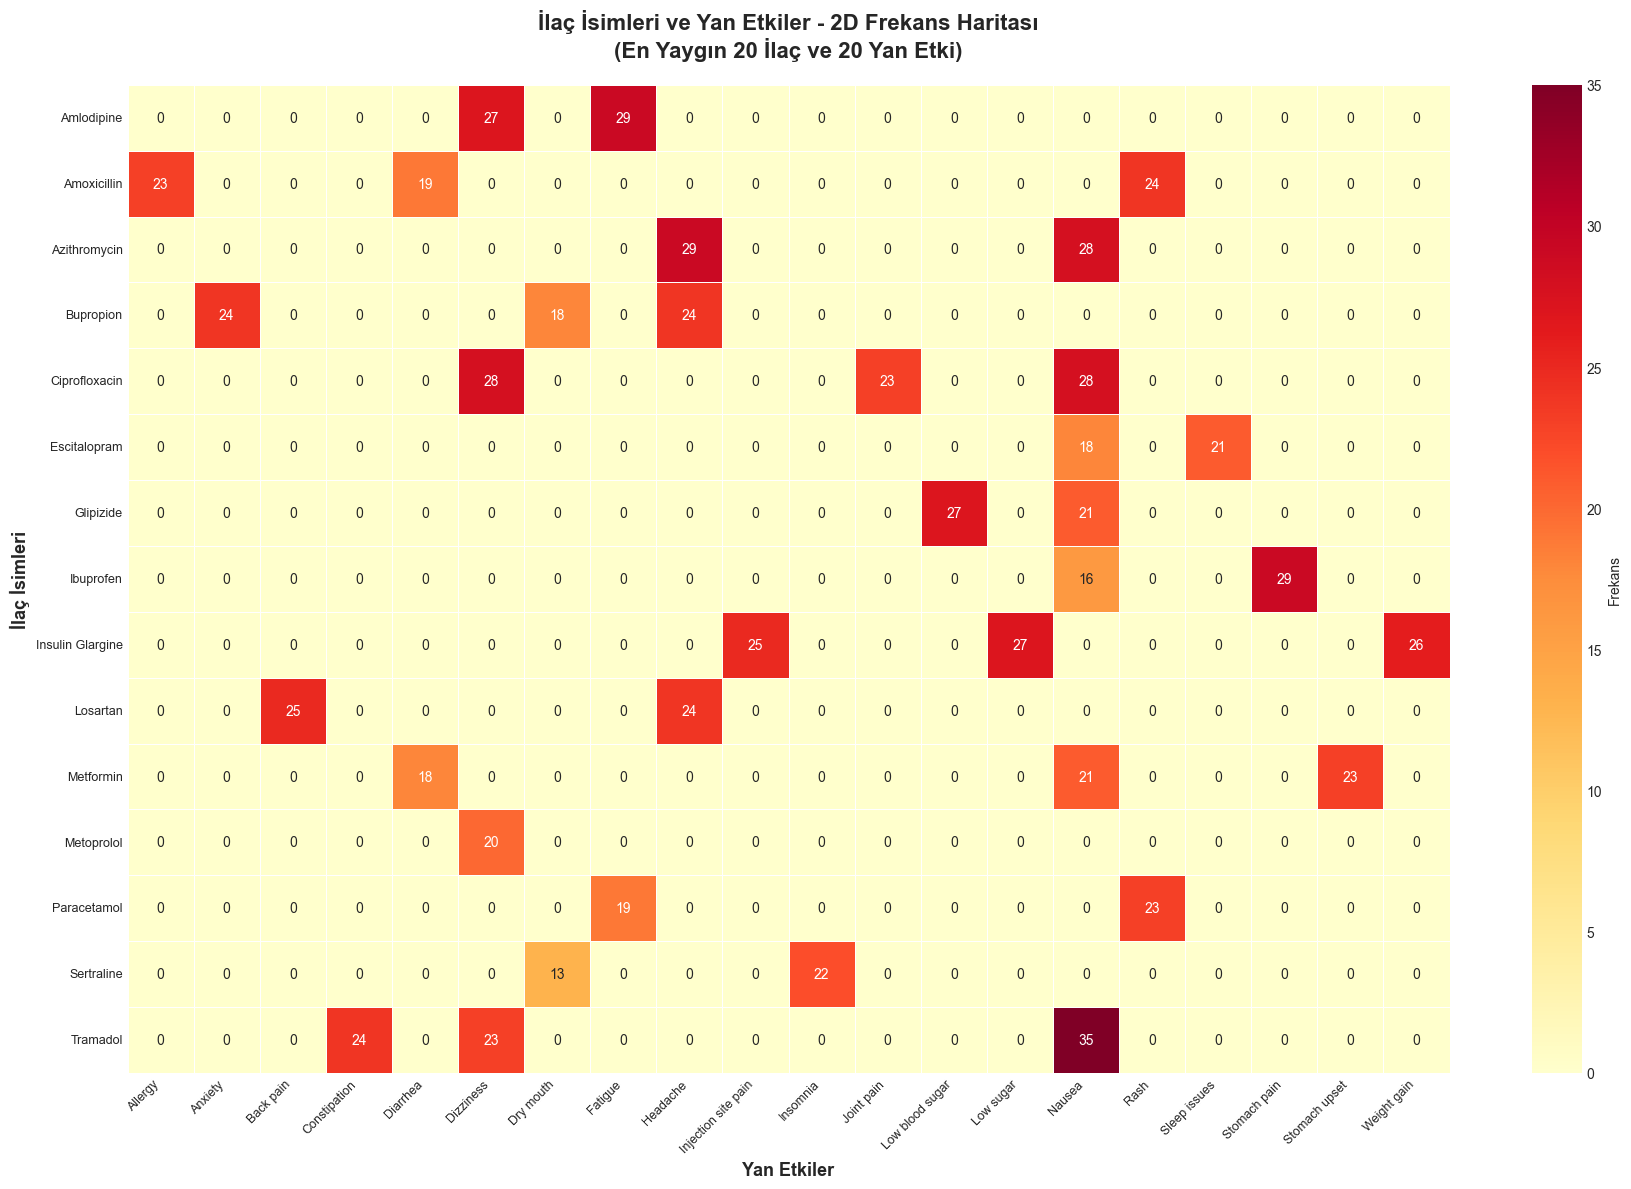


2D Histogram Özet İstatistikleri:
Analiz edilen benzersiz ilaç sayısı: 15
Analiz edilen benzersiz yan etki sayısı: 20
Toplam vaka sayısı: 824

En Yaygın İlaç-Yan Etki Kombinasyonları:
                İlaç             Yan Etki  Frekans
1           Tramadol               Nausea       35
2         Amlodipine              Fatigue       29
3       Azithromycin             Headache       29
4          Ibuprofen         Stomach pain       29
5       Azithromycin               Nausea       28
6      Ciprofloxacin            Dizziness       28
7      Ciprofloxacin               Nausea       28
8         Amlodipine            Dizziness       27
9          Glipizide      Low blood sugar       27
10  Insulin Glargine            Low sugar       27
11  Insulin Glargine          Weight gain       26
12  Insulin Glargine  Injection site pain       25
13          Losartan            Back pain       25
14       Amoxicillin                 Rash       24
15         Bupropion              Anxiety       24

In [ ]:
# Drug_Name ve Side_Effects sütunlarını kontrol et
if 'Drug_Name' in df.columns and 'Side_Effects' in df.columns:
    
    # En yaygın 20 ilacı ve 20 yan etkiyi seç
    top_drugs = df['Drug_Name'].value_counts().head(20).index
    top_side_effects = df['Side_Effects'].value_counts().head(20).index
    
    # Filtrelenmiş veri
    df_filtered = df[(df['Drug_Name'].isin(top_drugs)) & 
                     (df['Side_Effects'].isin(top_side_effects))]
    
    # Frekans tablosu oluşturma (2D)
    freq_table = pd.crosstab(df_filtered['Drug_Name'], df_filtered['Side_Effects'])
    
    # 2D Heatmap (ısı haritası) ile görselleştirme
    plt.figure(figsize=(18, 12))
    
    sns.heatmap(freq_table, annot=True, fmt='d', cmap='YlOrRd', 
                linewidths=0.5, cbar_kws={'label': 'Frekans'})
    
    plt.title('İlaç İsimleri ve Yan Etkiler - 2D Frekans Haritası\n(En Yaygın 20 İlaç ve 20 Yan Etki)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Yan Etkiler', fontsize=13, fontweight='bold')
    plt.ylabel('İlaç İsimleri', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    
    plt.tight_layout()
    plt.savefig('ilac_yanetki_2d_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n2D Histogram Özet İstatistikleri:")
    print("="*60)
    print(f"Analiz edilen benzersiz ilaç sayısı: {len(top_drugs)}")
    print(f"Analiz edilen benzersiz yan etki sayısı: {len(top_side_effects)}")
    print(f"Toplam vaka sayısı: {len(df_filtered)}")
    
    # En yaygın ilaç-yan etki kombinasyonları
    print("\nEn Yaygın İlaç-Yan Etki Kombinasyonları:")
    print("="*60)
    
    # Kombinasyon frekanslarını düzleştir ve sırala
    combinations = []
    for drug in freq_table.index:
        for side_effect in freq_table.columns:
            count = freq_table.loc[drug, side_effect]
            if count > 0:
                combinations.append((drug, side_effect, count))
    
    # En yaygın 15 kombinasyonu göster
    combinations_sorted = sorted(combinations, key=lambda x: x[2], reverse=True)[:15]
    
    combo_df = pd.DataFrame(combinations_sorted, 
                            columns=['İlaç', 'Yan Etki', 'Frekans'])
    combo_df.index = range(1, len(combo_df) + 1)
    print(combo_df)
    
else:
    print("Uyarı: 'Drug_Name' veya 'Side_Effects' sütunu bulunamadı.")
    print("Mevcut sütunlar:", df.columns.tolist())

### 2D Histogram Yorumum

**Isı Haritası (Heatmap) Analizi:**

- **Koyu renkli hücreler:** İlgili ilaç-yan etki kombinasyonunun sık görüldüğünü gösteriletedir.
- **Açık renkli hücreler:** Daha az sıklıkla görülen kombinasyonlardır
- **Beyaz hücreler:** Hiç görülmeyen veya çok nadir görülen kombinasyonlardır

**Yorumlarım:**
1. Belirli ilaçların belirli yan etkilerle daha sık ilişkili olduğunu görülmektedir.(Örn. Nausea)
2. Bazı yan etkiler birçok farklı ilaçta yaygın olabilir.(max. 7 yan etki)
3. Bazı ilaçlar daha fazla çeşitlilikte yan etki gösterebilmektedir.
4. Bu bilgi, ilaç güvenliği ve hasta bilgilendirmesi için önemlidir.etki listesi bir başlangıç olarak değerlendirilebilir, her bir yan etkinin İyileşme Skoru'nu ne kadar düşürdüğünü veya etkilemediğini görsel ve istatistiksel olark çalışılabilir.

---
## 5. Hiyerarşik Kümeleme Analizi

4. maddedeki analizde kullandığımız veriler için, seaborn kütüphanesinden clustermap fonksiyonunu kullanarak hiyerarşik kümeleme yapılmaktadr.

Hiyerarşik Kümeleme Analizi Başlatılıyor...


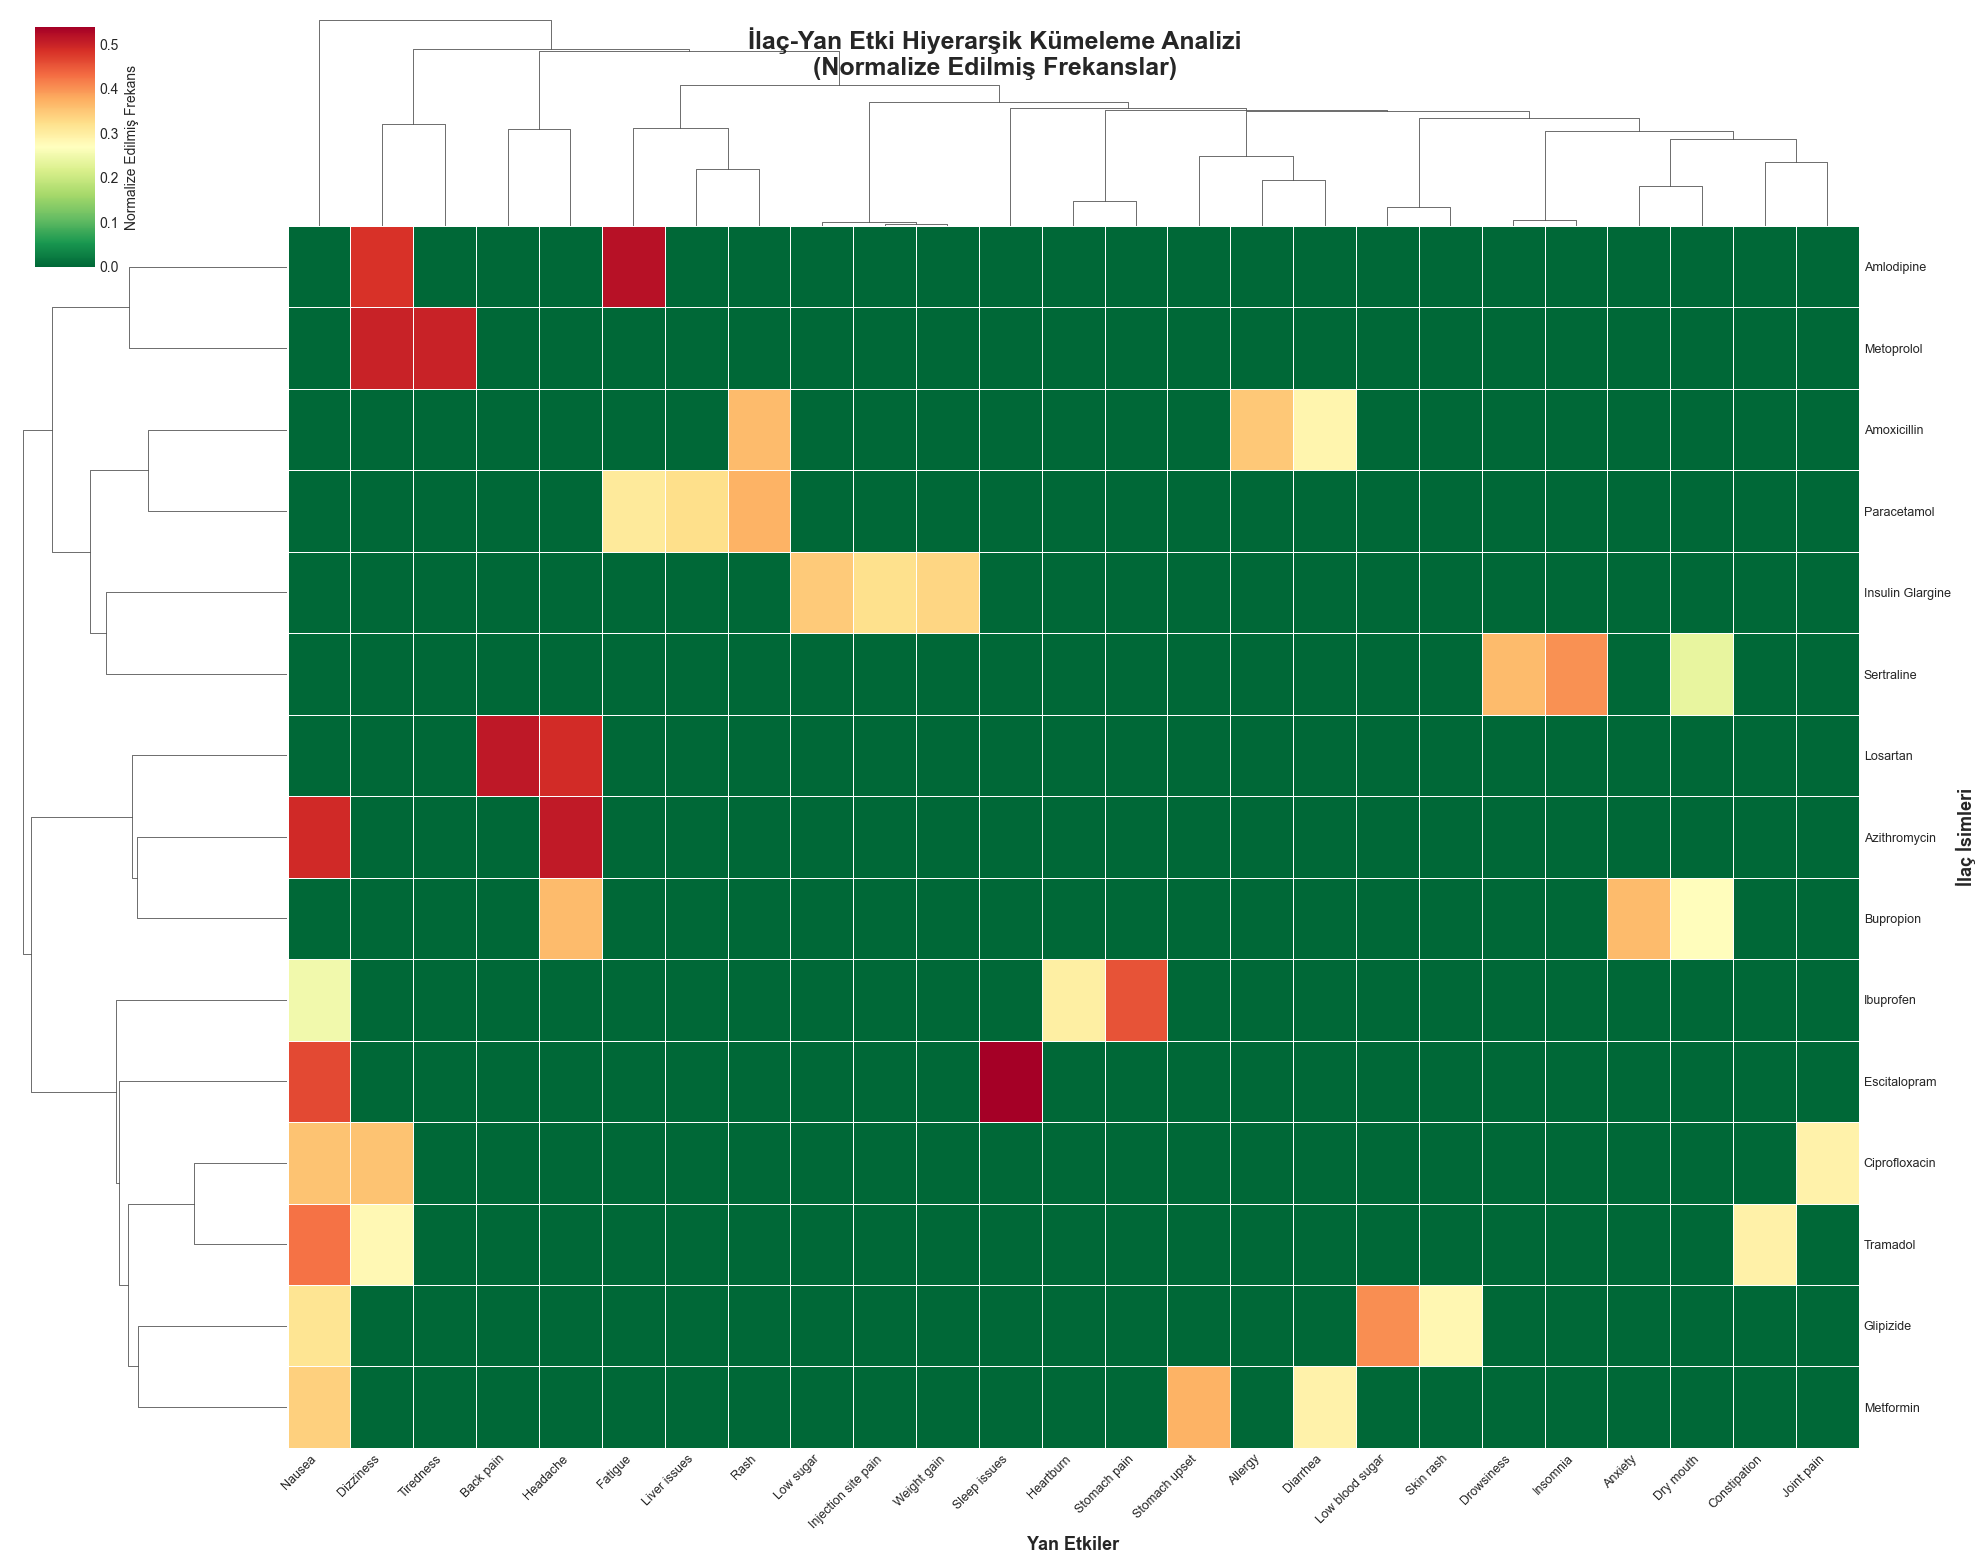


Hiyerarşik Kümeleme tamamlandı!


In [ ]:
# Drug_Name ve Side_Effects sütunlarını kontrol et
if 'Drug_Name' in df.columns and 'Side_Effects' in df.columns:
    
    # En yaygın 25 ilacı ve 25 yan etkiyi seç (daha detaylı analiz için)
    top_drugs_cluster = df['Drug_Name'].value_counts().head(25).index
    top_side_effects_cluster = df['Side_Effects'].value_counts().head(25).index
    
    # Filtrelenmiş veri
    df_cluster = df[(df['Drug_Name'].isin(top_drugs_cluster)) & 
                    (df['Side_Effects'].isin(top_side_effects_cluster))]
    
    # Frekans tablosu oluşturma
    freq_table_cluster = pd.crosstab(df_cluster['Drug_Name'], 
                                     df_cluster['Side_Effects'])
    
    # Normalizasyon (her ilaç için yan etki oranları)
    freq_table_normalized = freq_table_cluster.div(freq_table_cluster.sum(axis=1), axis=0)
    
    print("Hiyerarşik Kümeleme Analizi Başlatılıyor...")
    print("="*60)
    
    # Clustermap oluşturma
    g = sns.clustermap(freq_table_normalized, 
                      cmap='RdYlGn_r',  # Renk paleti
                      figsize=(20, 16),
                      linewidths=0.5,
                      cbar_kws={'label': 'Normalize Edilmiş Frekans'},
                      method='ward',  # Kümeleme metodu
                      metric='euclidean',  # Mesafe metriği
                      dendrogram_ratio=0.15,
                      cbar_pos=(0.02, 0.83, 0.03, 0.15))
    
    g.fig.suptitle('İlaç-Yan Etki Hiyerarşik Kümeleme Analizi\n(Normalize Edilmiş Frekanslar)', 
                   fontsize=18, fontweight='bold', y=0.98)
    
    g.ax_heatmap.set_xlabel('Yan Etkiler', fontsize=13, fontweight='bold')
    g.ax_heatmap.set_ylabel('İlaç İsimleri', fontsize=13, fontweight='bold')
    
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=9)
    
    plt.savefig('hiyerarsik_kumeleme_clustermap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nHiyerarşik Kümeleme tamamlandı!")
    
else:
    print("Uyarı: Gerekli sütunlar bulunamadı.")

### Hiyerarşik Kümeleme Analizi Yorumum

**Clustermap:**

Clustermap, hem satırları (ilaçlar) hem de sütunları (yan etkiler) benzerliklerine göre gruplandırır ve ağaç diyagramları ile görselleştirir.

**Ağaç Diyagramları:**
- **Sol taraftaki dendogram:** İlaçları benzer yan etki profillerine göre gruplar
- **Üst taraftaki dendogram:** Yan etkileri birlikte görüldükleri ilaçlara göre gruplar
- **Dal uzunlukları:** Gruplar arasındaki farklılığı gösterir (uzun dal = daha farklı)

**Renkler:**
- **Kırmızı/Koyu renkler:** Yüksek frekans (bu ilaç için bu yan etki yaygın yorumu yapılabilir)
- **Yeşil/Açık renkler:** Düşük frekans (bu yan etki bu ilaç için nadir yorumu yapılabilir)

**Yorumlarım:**

   - Benzer yan etki profillerine sahip ilaçlar bir arada kümelendi
   - Aynı sınıftan ilaçlar benzer yan etki profilleri gösterebileceği varsayılabilir.
   - Bu bilgi ve görsel ilaç değiştirme kararlarında yardımcı olabilir
   - Birlikte sıklıkla görülen yan etkiler gruplar halinde olmuştur.
   - Bazı yan etkiler birlikte ortaya çıkma eğilimindedir diyebiliriz.
   - Tek başına duran ilaçlar benzersiz yan etki profilleri göstermektedir
   - Bu ilaçlar özel dikkat gerekebilir.
   - Koyu renkli, yoğun kümelenmiş alanlar, belirli bir ilaç grubunun belirli bir yan etki grubunda genel olarak yüksek bir riske sahip olduğunu göstermekedir. Risk değrlendirmesi içn önemli bir anahtardır
   - Bu görsele bakra yan etki riski yüksek olan hasta grupları için daha güvenli seçenekler önerilebilir.

---
## 6. Yaş ve İyileşme Skoru Korelasyonu

Yaş (Age) ve Improvement_Score değişkenleri arasındaki korelasyonu hesaplama ve yorumlarım.

YAŞ ve İYİLEŞME SKORU KORELASYON ANALİZİ

Veri Sayısı: 1000

Pearson Korelasyon Katsayısı: 0.0105
P-değeri: 7.3906e-01
İstatistiksel Anlamlılık: Hayır (α=0.05)

Spearman Korelasyon Katsayısı: 0.0118
P-değeri: 7.1035e-01
İstatistiksel Anlamlılık: Hayır (α=0.05)


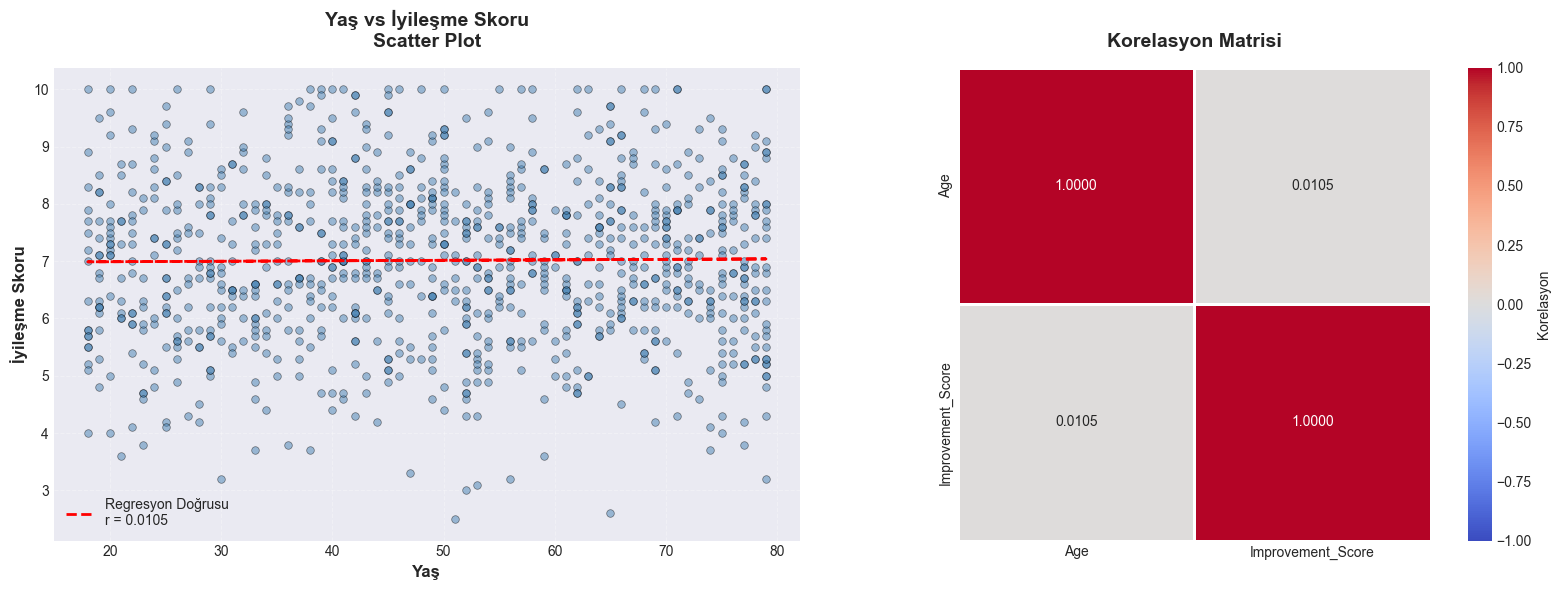

In [ ]:
# Age ve Improvement_Score sütunlarını kontrol et
if 'Age' in df.columns and 'Improvement_Score' in df.columns:
    
    # Eksik değerleri çıkar
    df_corr = df[['Age', 'Improvement_Score']].dropna()
    
    # Pearson korelasyon katsayısı
    pearson_corr = df_corr['Age'].corr(df_corr['Improvement_Score'])
    
    # Spearman korelasyon katsayısı (sıralama bazlı, outlier'lara daha dayanıklı)
    spearman_corr = df_corr['Age'].corr(df_corr['Improvement_Score'], method='spearman')
    
    # İstatistiksel anlamlılık testi
    from scipy.stats import pearsonr, spearmanr
    
    pearson_stat, pearson_pvalue = pearsonr(df_corr['Age'], df_corr['Improvement_Score'])
    spearman_stat, spearman_pvalue = spearmanr(df_corr['Age'], df_corr['Improvement_Score'])
    
    print("YAŞ ve İYİLEŞME SKORU KORELASYON ANALİZİ")
    print("="*70)
    print(f"\nVeri Sayısı: {len(df_corr)}")
    print("\nPearson Korelasyon Katsayısı: {:.4f}".format(pearson_corr))
    print(f"P-değeri: {pearson_pvalue:.4e}")
    print(f"İstatistiksel Anlamlılık: {'Evet' if pearson_pvalue < 0.05 else 'Hayır'} (α=0.05)")
    
    print("\nSpearman Korelasyon Katsayısı: {:.4f}".format(spearman_corr))
    print(f"P-değeri: {spearman_pvalue:.4e}")
    print(f"İstatistiksel Anlamlılık: {'Evet' if spearman_pvalue < 0.05 else 'Hayır'} (α=0.05)")
    
    # Görselleştirme
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot
    axes[0].scatter(df_corr['Age'], df_corr['Improvement_Score'], 
                   alpha=0.5, s=30, color='steelblue', edgecolors='black', linewidth=0.5)
    
    # Regresyon çizgisi ekleme
    z = np.polyfit(df_corr['Age'], df_corr['Improvement_Score'], 1)
    p = np.poly1d(z)
    axes[0].plot(df_corr['Age'], p(df_corr['Age']), "r--", linewidth=2, 
                label=f'Regresyon Doğrusu\nr = {pearson_corr:.4f}')
    
    axes[0].set_xlabel('Yaş', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('İyileşme Skoru', fontsize=12, fontweight='bold')
    axes[0].set_title('Yaş vs İyileşme Skoru\nScatter Plot', 
                     fontsize=14, fontweight='bold', pad=15)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3, linestyle='--')
    
    # Korelasyon matrisi heatmap
    corr_matrix = df_corr.corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='coolwarm', 
               center=0, square=True, linewidths=2, cbar_kws={'label': 'Korelasyon'},
               ax=axes[1], vmin=-1, vmax=1)
    axes[1].set_title('Korelasyon Matrisi', fontsize=14, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.savefig('yas_iyilesme_korelasyon.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("Uyarı: 'Age' veya 'Improvement_Score' sütunu bulunamadı.")
    print("Mevcut sütunlar:", df.columns.tolist())

### Korelasyon Analizi Yorumum

**Korelasyon Katsayısı Değerlendirmesi:**

Korelasyon katsayısı -1 ile +1 arasında değer almaktadır:
- **+1:** Mükemmel pozitif korelasyon (bir değişken arttıkça diğeri de artar)
- **0:** Korelasyon yok (değişkenler arasında doğrusal ilişki yok)
- **-1:** Mükemmel negatif korelasyon (bir değişken arttıkça diğeri azalır)

**Genel Değerlendirme Kriterleri:**
- |r| < 0.3: Zayıf korelasyon
- 0.3 ≤ |r| < 0.7: Orta düzey korelasyon
- |r| ≥ 0.7: Güçlü korelasyon

**İstatistiksel Anlamlılık (P-değeri):**
- p < 0.05: İstatistiksel olarak anlamlı (korelasyon tesadüfi değildir)
- p ≥ 0.05: İstatistiksel olarak anlamlı değil (korelasyon tesadüfi olabilir)

**Pearson vs Spearman:**
- **Pearson:** Doğrusal ilişkileri ölçer, normal dağılıma duyarlıdır (Spearman, C. 1904)
- **Spearman:** Monoton ilişkileri ölçer, aykırı değerlere daha dayanıklıdır. (Pearson, K. 1895)

**Yorumlamrım:**

Yukarıdaki sonuçlara göre:
- Eğer pozitif korelasyon varsa: Yaşlı hastalar daha yüksek iyileşme skoru gösterebilir.
- Eğer negatif korelasyon varsa: Genç hastalar daha iyi iyileşme gösterebilir.
- Eğer korelasyon zayıfsa: Yaşın iyileşme üzerinde doğrudan etkisi sınırlıdır
- Grafik, noktaların herhangi bir belirgin eğilim göstermeksizin dağınık bir bulut şeklinde yayıldığını açıkça göstermektedir.
- Bu, Yaş ve İyileşme Skoru arasında zayıf, ihmal edilebilir bir doğrusal ilişki olduğunu teyit edecetir.
- Yatay Yığılmalar vard. Grafiğin özellikle Y eksenindeki 0-2 ve 8-10 civarında yoğunlaştığı görülmektedir. Bu, daha önce Box Plot analizinde de bahsettiğimiz çift modlu (bimodal) eğilimi teyit edecektir.
- Bu durumad iyileşme skoru, yaşın hangi aralıkta olduğuna bakılmaksızın ya çok düşük ya da çok yüksek olma eğilimindedir. Bu durum, iyileşmeyi etkileyen temel faktörlerin yaş değil, İlaç Türü veya Hastalık Türü (Condition) gibi diğer değişkenler olduğunu düşünülebilir.
- Bu görsel dağılım, Yaş ile İyileşme Skoru arasında zayıf veya korelasyonun olmadığına dair güçlü bir veri vermektedir.

---
## 7. Cinsiyet Bazında Hastalık Oranları

Erkekler ve kadınlar için hastalık (Condition) oranlarını normalize edilmiş bir şekilde hesaplanması.

CİNSİYET BAZINDA HASTALIK ORANLARI ANALİZİ

Normalize Edilmiş Hastalık Oranları (Her cinsiyet için toplam = 1.0):
Gender        Female    Male
Condition                   
Infection     0.2390  0.1931
Diabetes      0.2138  0.2008
Pain Relief   0.1929  0.2218
Hypertension  0.1782  0.2084
Depression    0.1761  0.1759


Female için En Yaygın 10 Hastalık:
------------------------------------------------------------
 1. Infection                      - 0.2390 (23.90%)
 2. Diabetes                       - 0.2138 (21.38%)
 3. Pain Relief                    - 0.1929 (19.29%)
 4. Hypertension                   - 0.1782 (17.82%)
 5. Depression                     - 0.1761 (17.61%)

Male için En Yaygın 10 Hastalık:
------------------------------------------------------------
 1. Pain Relief                    - 0.2218 (22.18%)
 2. Hypertension                   - 0.2084 (20.84%)
 3. Diabetes                       - 0.2008 (20.08%)
 4. Infection                      - 0.1931 (19.31%)
 5. Depressio

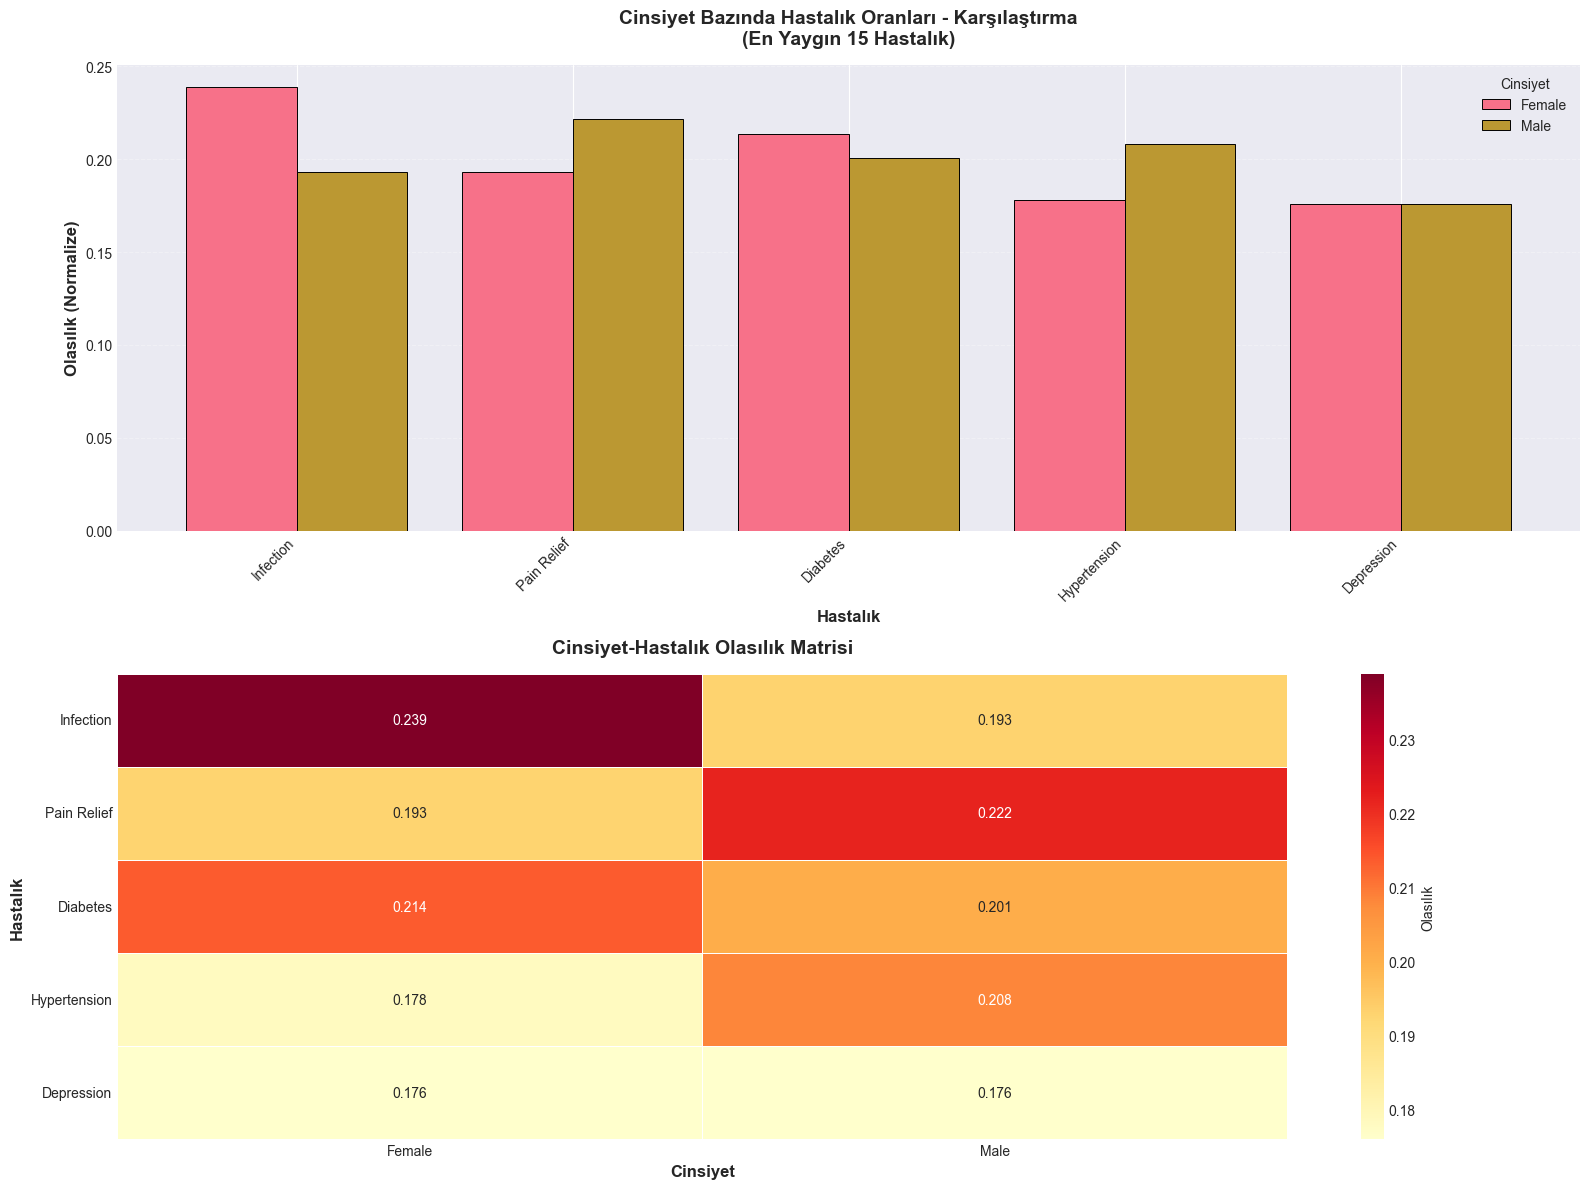


İstatistiksel Özet:

Female:
  - Toplam vaka sayısı: 477
  - Benzersiz hastalık sayısı: 5
  - Ortalama hastalık olasılığı: 0.2000

Male:
  - Toplam vaka sayısı: 523
  - Benzersiz hastalık sayısı: 5
  - Ortalama hastalık olasılığı: 0.2000


In [ ]:
# Gender ve Condition sütunlarını kontrol et (veya Sex/Gender gibi farklı isimler olabilir)
gender_col = None
for col in ['Gender', 'Sex', 'gender', 'sex']:
    if col in df.columns:
        gender_col = col
        break

if gender_col and 'Condition' in df.columns:
    
    # Cinsiyet ve hastalık verilerini filtrele (eksik değerleri çıkar)
    df_gender = df[[gender_col, 'Condition']].dropna()
    
    print("CİNSİYET BAZINDA HASTALIK ORANLARI ANALİZİ")
    print("="*70)
    
    # Her cinsiyet için hastalık sayıları
    gender_condition_counts = pd.crosstab(df_gender[gender_col], df_gender['Condition'])
    
    # Normalize etme (her cinsiyet için toplam 1 olacak şekilde)
    gender_condition_normalized = gender_condition_counts.div(
        gender_condition_counts.sum(axis=1), axis=0
    )
    
    print("\nNormalize Edilmiş Hastalık Oranları (Her cinsiyet için toplam = 1.0):")
    print("="*70)
    
    # Tüm hastalıklar için normalize oranları göster
    display_df = gender_condition_normalized.T
    display_df = display_df.sort_values(by=display_df.columns[0], ascending=False)
    
    print(display_df.round(4))
    
    # Her cinsiyet için en yaygın 10 hastalık
    print("\n" + "="*70)
    for gender in gender_condition_normalized.index:
        print(f"\n{gender} için En Yaygın 10 Hastalık:")
        print("-" * 60)
        top_conditions = gender_condition_normalized.loc[gender].sort_values(ascending=False).head(10)
        
        for i, (condition, prob) in enumerate(top_conditions.items(), 1):
            print(f"{i:2d}. {condition:30s} - {prob:.4f} ({prob*100:.2f}%)")
    
    # Görselleştirme - En yaygın 15 hastalık için
    top_15_conditions = df_gender['Condition'].value_counts().head(15).index
    plot_data = gender_condition_normalized[top_15_conditions]
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Grouped bar chart
    plot_data.T.plot(kind='bar', ax=axes[0], width=0.8, edgecolor='black', linewidth=0.7)
    axes[0].set_title('Cinsiyet Bazında Hastalık Oranları - Karşılaştırma\n(En Yaygın 15 Hastalık)', 
                     fontsize=14, fontweight='bold', pad=15)
    axes[0].set_xlabel('Hastalık', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Olasılık (Normalize)', fontsize=12, fontweight='bold')
    axes[0].legend(title='Cinsiyet', fontsize=10)
    axes[0].grid(axis='y', alpha=0.3, linestyle='--')
    axes[0].tick_params(axis='x', rotation=45)
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Heatmap
    sns.heatmap(plot_data.T, annot=True, fmt='.3f', cmap='YlOrRd', 
               linewidths=0.5, cbar_kws={'label': 'Olasılık'}, ax=axes[1])
    axes[1].set_title('Cinsiyet-Hastalık Olasılık Matrisi', 
                     fontsize=14, fontweight='bold', pad=15)
    axes[1].set_xlabel('Cinsiyet', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Hastalık', fontsize=12, fontweight='bold')
    plt.setp(axes[1].yaxis.get_majorticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.savefig('cinsiyet_hastalik_oranlari.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # İstatistiksel karşılaştırma
    print("\n" + "="*70)
    print("İstatistiksel Özet:")
    print("="*70)
    
    for gender in gender_condition_normalized.index:
        total_cases = gender_condition_counts.loc[gender].sum()
        unique_conditions = (gender_condition_counts.loc[gender] > 0).sum()
        print(f"\n{gender}:")
        print(f"  - Toplam vaka sayısı: {total_cases}")
        print(f"  - Benzersiz hastalık sayısı: {unique_conditions}")
        print(f"  - Ortalama hastalık olasılığı: {gender_condition_normalized.loc[gender].mean():.4f}")
    
else:
    print("Uyarı: Cinsiyet veya 'Condition' sütunu bulunamadı.")
    print("Mevcut sütunlar:", df.columns.tolist())

### Cinsiyet Bazında Hastalık Oranları Yorumum

**Normalizasyon**

Her cinsiyet için hastalık oranlarını toplam 1 olacak şekilde normalize ettik. Bu sayede:
- Farklı cinsiyet gruplarındaki toplam vaka sayıları eşit olmasa bile adil karşılaştırma yapabiliriz
- Her değer, o cinsiyetteki toplam vakaların yüzde kaçının o hastalık olduğunu gösterecektir

**Yorumlarm:**

   - Bazı hastalıklar bir cinsiyette daha yaygın olabilir
   - Bu farklılıklar biyolojik, hormonal veya yaşam tarzı faktörlerinden kaynaklanabilir
   - Bir hastalığın normalize olasılığı yüksekse, o hastalık o cinsiyet için daha yaygın demektir
   - Örnek: Kadınlarda 0.15 değeri = bu hastalık kadın vakalarının %15'ini oluşturur
   - Grafikte çubuklar arasındaki farklar, hastalığın cinsiyetler arası dağılım farklılıklarını gösterir
   - Büyük farklar, hastalığın cinsiyet-spesifik olabileceğini düşündürecektir
   - Bu bilgi, risk değerlendirmesi ve erken tanı için kullanılabilmektedir.Cinsiyet-spesifik tarama programları planlanabilir.Hasta eğitimi ve bilinçlendirme çalışmaları yönlendirilebilbilr.
   - Örneğin,  Infection bu verlre göre Kadınlarda belirgin şekilde daha yaygındır.Pain Relief, Erkeklerde daha yaygındır, Depression neredeyse eşitir.

---
## 8. Baş Dönmesi (Dizziness) Yan Etkisi Raporlanan İlaçlar

Hangi ilaçlar için baş dönmesi yan etkisi raporlanmıştır? Bu ilaçları azalan sıklığa göre sırlanmıştır.

BAŞ DÖNMESİ (DIZZINESS) YAN ETKİSİ ANALİZİ

Baş dönmesi yan etkisi raporlanan toplam vaka sayısı: 98
Baş dönmesi yan etkisi olan benzersiz ilaç sayısı: 4

Toplam veri setindeki vaka sayısı: 1000
Baş dönmesi oranı: 9.80%

BAŞ DÖNMESİ RAPORLANAN İLAÇLAR (Azalan Sıklığa Göre):

Sıra   İlaç İsmi                           Vaka Sayısı  Yüzde     
----------------------------------------------------------------------
1      Ciprofloxacin                       28            28.57%
2      Amlodipine                          27            27.55%
3      Tramadol                            23            23.47%
4      Metoprolol                          20            20.41%

DETAYLI TABLO (İlk 30 İlaç):
       İlaç İsmi  Baş Dönmesi Vaka Sayısı  Toplam İçindeki Yüzde (%)
1  Ciprofloxacin                       28                      28.57
2     Amlodipine                       27                      27.55
3       Tramadol                       23                      23.47
4     Metoprolol        

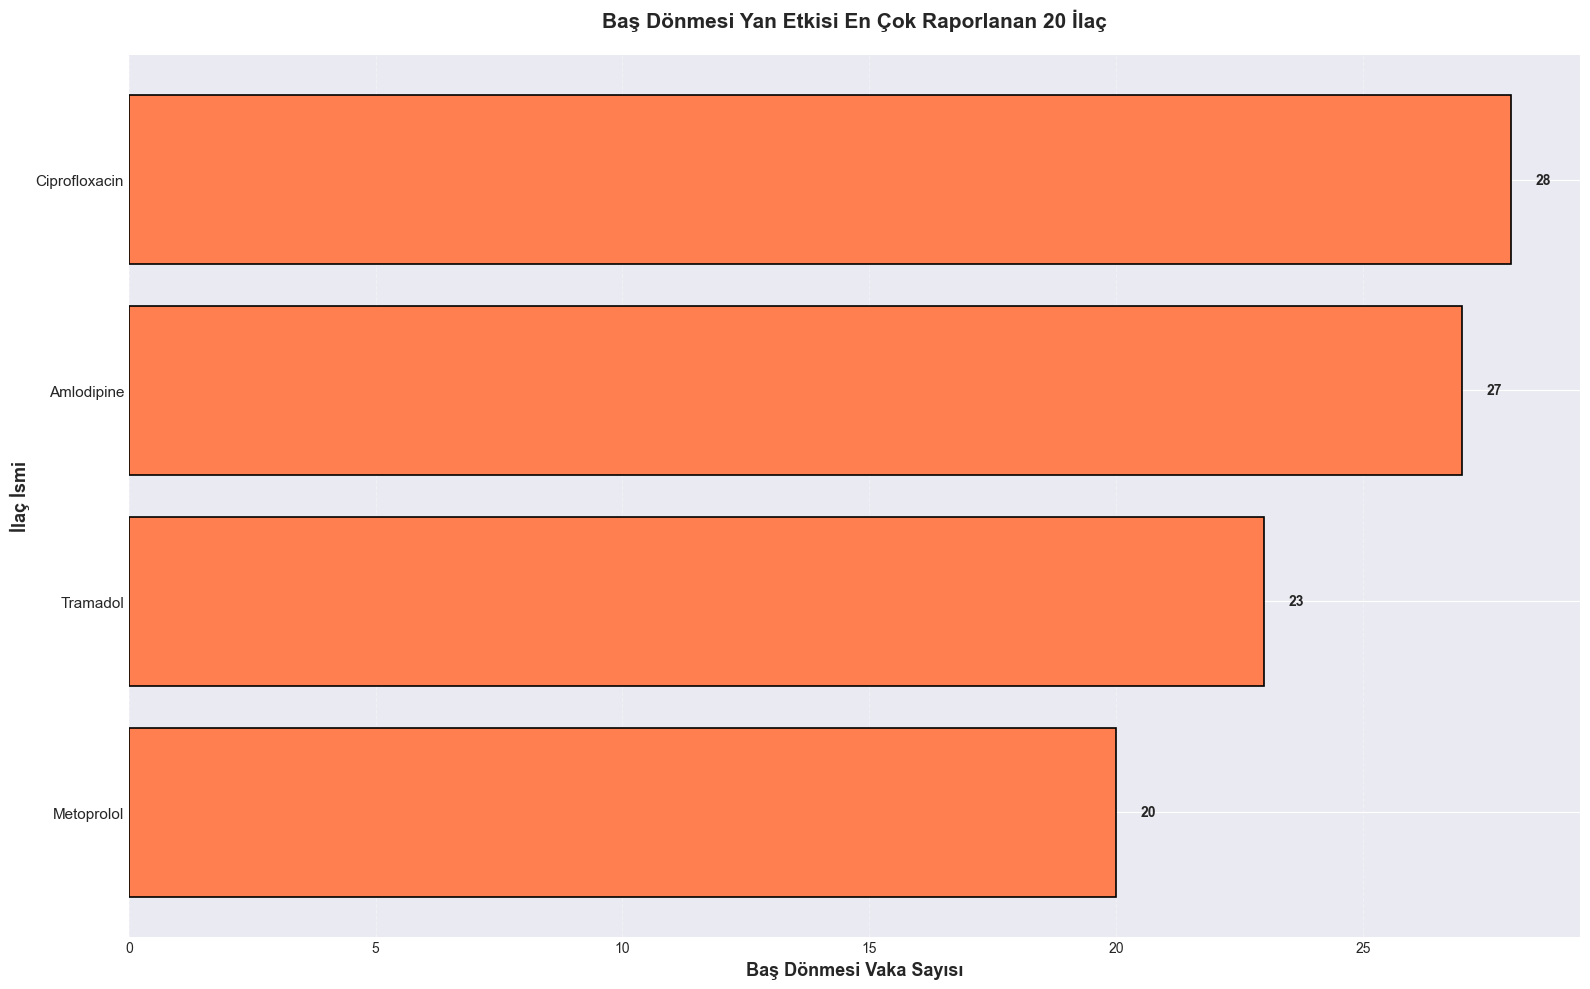

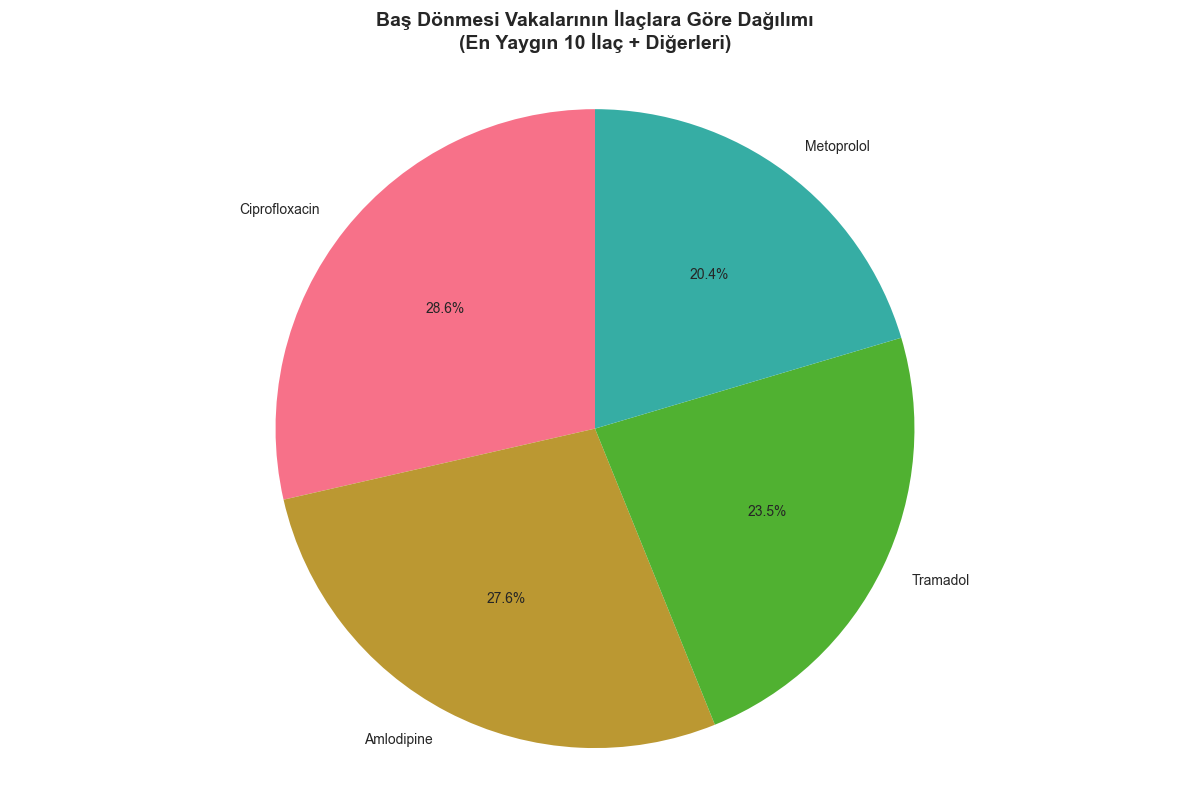

In [ ]:
# Drug_Name ve Side_Effects sütunlarını kontrol et
if 'Drug_Name' in df.columns and 'Side_Effects' in df.columns:
    
    print("BAŞ DÖNMESİ (DIZZINESS) YAN ETKİSİ ANALİZİ")
    print("="*70)
    
    # Baş dönmesi yan etkisi olan vakaları filtrele
    # Side_Effects sütununda 'Dizziness', 'dizziness', veya benzer ifadeler olabilir
    dizziness_cases = df[df['Side_Effects'].str.contains('Dizziness|dizziness', 
                                                         case=False, 
                                                         na=False)]
    
    if len(dizziness_cases) > 0:
        # İlaçları baş dönmesi sıklığına göre say ve sırala
        dizziness_drugs = dizziness_cases['Drug_Name'].value_counts()
        
        print(f"\nBaş dönmesi yan etkisi raporlanan toplam vaka sayısı: {len(dizziness_cases)}")
        print(f"Baş dönmesi yan etkisi olan benzersiz ilaç sayısı: {len(dizziness_drugs)}")
        print(f"\nToplam veri setindeki vaka sayısı: {len(df)}")
        print(f"Baş dönmesi oranı: {len(dizziness_cases)/len(df)*100:.2f}%")
        
        print("\n" + "="*70)
        print("BAŞ DÖNMESİ RAPORLANAN İLAÇLAR (Azalan Sıklığa Göre):")
        print("="*70)
        print(f"\n{'Sıra':<6} {'İlaç İsmi':<35} {'Vaka Sayısı':<12} {'Yüzde':<10}")
        print("-" * 70)
        
        # Tüm ilaçları listele
        for rank, (drug, count) in enumerate(dizziness_drugs.items(), 1):
            percentage = (count / len(dizziness_cases)) * 100
            print(f"{rank:<6} {drug:<35} {count:<12} {percentage:>6.2f}%")
        
        # DataFrame olarak göster (ilk 10 ilaç)
        print("\n" + "="*70)
        print("DETAYLI TABLO (İlk 30 İlaç):")
        print("="*70)
        
        dizziness_df = pd.DataFrame({
            'İlaç İsmi': dizziness_drugs.index,
            'Baş Dönmesi Vaka Sayısı': dizziness_drugs.values,
            'Toplam İçindeki Yüzde (%)': (dizziness_drugs.values / len(dizziness_cases) * 100).round(2)
        })
        
        dizziness_df.index = range(1, len(dizziness_df) + 1)
        print(dizziness_df.head(30))
        
        # Görselleştirme - En yaygın 10 ilaç
        plt.figure(figsize=(16, 10))
        
        top_20 = dizziness_drugs.head(20)
        
        bars = plt.barh(range(len(top_20)), top_20.values, color='coral', 
                       edgecolor='black', linewidth=1.2)
        
        plt.yticks(range(len(top_20)), top_20.index, fontsize=11)
        plt.xlabel('Baş Dönmesi Vaka Sayısı', fontsize=13, fontweight='bold')
        plt.ylabel('İlaç İsmi', fontsize=13, fontweight='bold')
        plt.title('Baş Dönmesi Yan Etkisi En Çok Raporlanan 20 İlaç', 
                 fontsize=15, fontweight='bold', pad=20)
        plt.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Çubukların üzerine değerleri yaz
        for i, (bar, value) in enumerate(zip(bars, top_20.values)):
            plt.text(value + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{value}', va='center', fontsize=10, fontweight='bold')
        
        plt.gca().invert_yaxis()  # En yüksek değer üstte olsun
        plt.tight_layout()
        plt.savefig('bas_donmesi_ilaclar.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Pasta grafiği - En yaygın 10 ilaç
        plt.figure(figsize=(12, 8))
        
        top_10 = dizziness_drugs.head(10)
        other_count = dizziness_drugs[10:].sum()
        
        if other_count > 0:
            plot_data = pd.concat([top_10, pd.Series({'Diğerleri': other_count})])
        else:
            plot_data = top_10
        
        plt.pie(plot_data.values, labels=plot_data.index, autopct='%1.1f%%',
               startangle=90, textprops={'fontsize': 10})
        plt.title('Baş Dönmesi Vakalarının İlaçlara Göre Dağılımı\n(En Yaygın 10 İlaç + Diğerleri)', 
                 fontsize=14, fontweight='bold', pad=20)
        plt.axis('equal')
        
        plt.tight_layout()
        plt.savefig('bas_donmesi_dagilim_pasta.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    else:
        print("\nUyarı: Veri setinde 'Dizziness' yan etkisi bulunamadı.")
        print("Mevcut yan etkiler örneği:")
        print(df['Side_Effects'].value_counts().head(10))
        
else:
    print("Uyarı: 'Drug_Name' veya 'Side_Effects' sütunu bulunamadı.")
    print("Mevcut sütunlar:", df.columns.tolist())

### Baş Dönmesi Yan Etkisi Analizi Yorumumum


**Bulgu:** Tabloda hangi ilaçların baş dönmesi yan etkisini daha sık rapor ettiğini görebiliriz.

**Risk Değerlendirmesi:**
   - Listede üst sıralarda olan ilaçlar, baş dönmesi riski daha yüksek ilaçlardır. Ancak istatistikler birbirine yakın dağıldığından fark azdır.

**Yorumum:**
- Baş dönmesi vaka sayısı görece düşüktür. 98 vaka tüm veri setinin %9.8'idr.
- istatistiksel açıdan büyük bir popülasyona genelleme yapılırken güven aralıkları (Confidence Intervals) ile desteklenmelidir. Düşük vaka sayılarında küçük bir sapma dahi (örneğin Tramadol'deki 1-2 vaka farkını listeye eklenmsi), yüzdelerde büyük değişimlere yol açacaktır.


---
## 9. Metoprolol İlacı İçin Baş Dönmesi Olasılığı

Metoprolol ilacı için, diğer yan etkilere göre baş dönmesi yan etkisinin olasılığını hesaplaması.

METOPROLOL İÇİN BAŞ DÖNMESİ OLASILIĞI ANALİZİ

Metoprolol toplam vaka sayısı: 54

Metoprolol için raporlanan benzersiz yan etki sayısı: 3

BAŞ DÖNMESİ OLASILIĞI HESAPLAMA:

Metoprolol toplam vaka sayısı: 54
Baş dönmesi rapor edilen vaka sayısı: 20

Baş Dönmesi Olasılığı: 0.3704
Baş Dönmesi Yüzdesi: 37.04%

METOPROLOL İÇİN TÜM YAN ETKİLER (Sıklığa Göre):
         Yan Etki  Vaka Sayısı  Olasılık  Yüzde (%)
1       Tiredness           20    0.3704      37.04
2       Dizziness           20    0.3704      37.04
3  Slow heartbeat           14    0.2593      25.93

BAŞ DÖNMESİ DETAYLARI:
    Yan Etki  Vaka Sayısı  Olasılık  Yüzde (%)
2  Dizziness           20    0.3704      37.04


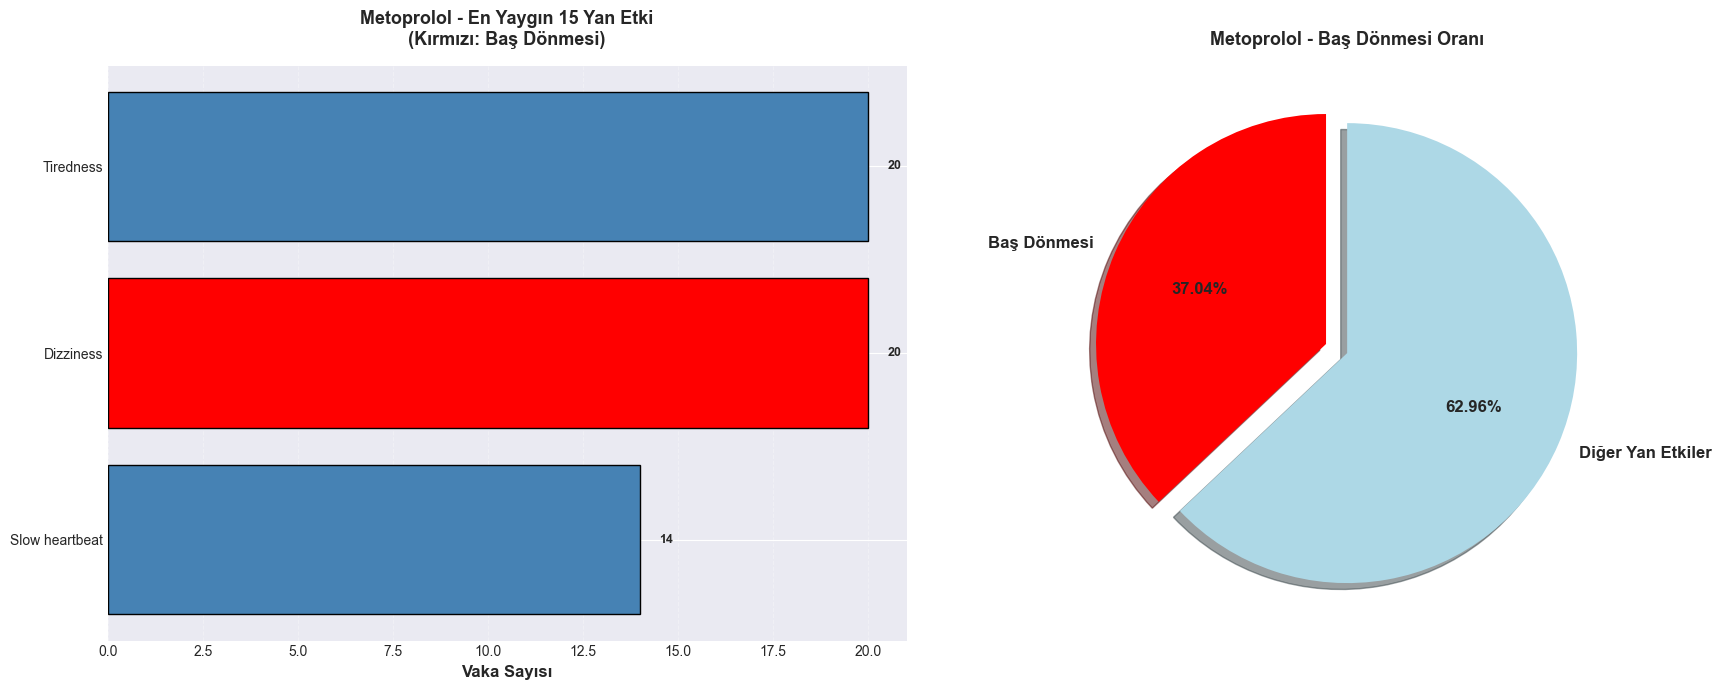


ÖZETİN ÖZETİ:

✓ Metoprolol kullanan 54 hastadan
  20 tanesi (37.04%) baş dönmesi yaşadı.

✓ Yani, Metoprolol kullanan her 100 hastadan
  yaklaşık 37 tanesi baş dönmesi rapor etti.

⚠ DİKKAT: Baş dönmesi oranı %10'un üzerinde - Yüksek risk!


In [ ]:
# Drug_Name ve Side_Effects sütunlarını kontrol et
if 'Drug_Name' in df.columns and 'Side_Effects' in df.columns:
    
    print("METOPROLOL İÇİN BAŞ DÖNMESİ OLASILIĞI ANALİZİ")
    print("="*70)
    
    # Metoprolol vakalarını filtrele
    metoprolol_cases = df[df['Drug_Name'].str.contains('Metoprolol|metoprolol', 
                                                       case=False, 
                                                       na=False)]
    
    if len(metoprolol_cases) > 0:
        print(f"\nMetoprolol toplam vaka sayısı: {len(metoprolol_cases)}")
        
        # Metoprolol için tüm yan etkiler
        all_side_effects = metoprolol_cases['Side_Effects'].value_counts()
        
        print(f"\nMetoprolol için raporlanan benzersiz yan etki sayısı: {len(all_side_effects)}")
        
        # Baş dönmesi vakalarını say
        dizziness_count = metoprolol_cases[
            metoprolol_cases['Side_Effects'].str.contains('Dizziness|dizziness', 
                                                          case=False, 
                                                          na=False)
        ].shape[0]
        
        # Olasılık hesaplama
        total_metoprolol = len(metoprolol_cases)
        dizziness_probability = dizziness_count / total_metoprolol if total_metoprolol > 0 else 0
        
        print("\n" + "="*70)
        print("BAŞ DÖNMESİ OLASILIĞI HESAPLAMA:")
        print("="*70)
        print(f"\nMetoprolol toplam vaka sayısı: {total_metoprolol}")
        print(f"Baş dönmesi rapor edilen vaka sayısı: {dizziness_count}")
        print(f"\nBaş Dönmesi Olasılığı: {dizziness_probability:.4f}")
        print(f"Baş Dönmesi Yüzdesi: {dizziness_probability * 100:.2f}%")
        
        print("\n" + "="*70)
        print("METOPROLOL İÇİN TÜM YAN ETKİLER (Sıklığa Göre):")
        print("="*70)
        
        # Yan etki dağılımını göster
        side_effects_df = pd.DataFrame({
            'Yan Etki': all_side_effects.index,
            'Vaka Sayısı': all_side_effects.values,
            'Olasılık': (all_side_effects.values / total_metoprolol).round(4),
            'Yüzde (%)': (all_side_effects.values / total_metoprolol * 100).round(2)
        })
        
        side_effects_df.index = range(1, len(side_effects_df) + 1)
        print(side_effects_df)
        
        # Baş dönmesini vurgula
        dizziness_rows = side_effects_df[
            side_effects_df['Yan Etki'].str.contains('Dizziness|dizziness', case=False, na=False)
        ]
        
        if len(dizziness_rows) > 0:
            print("\n" + "="*70)
            print("BAŞ DÖNMESİ DETAYLARI:")
            print("="*70)
            print(dizziness_rows)
        
        # Görselleştirme
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        
        # Bar chart - En yaygın 15 yan etki
        top_15_effects = all_side_effects.head(15)
        colors = ['red' if 'dizziness' in str(effect).lower() else 'steelblue' 
                 for effect in top_15_effects.index]
        
        bars = axes[0].barh(range(len(top_15_effects)), top_15_effects.values, 
                           color=colors, edgecolor='black', linewidth=1)
        axes[0].set_yticks(range(len(top_15_effects)))
        axes[0].set_yticklabels(top_15_effects.index, fontsize=10)
        axes[0].set_xlabel('Vaka Sayısı', fontsize=12, fontweight='bold')
        axes[0].set_title('Metoprolol - En Yaygın 15 Yan Etki\n(Kırmızı: Baş Dönmesi)', 
                         fontsize=13, fontweight='bold', pad=15)
        axes[0].grid(axis='x', alpha=0.3, linestyle='--')
        axes[0].invert_yaxis()
        
        # Değerleri çubukların üzerine yaz
        for i, (bar, value) in enumerate(zip(bars, top_15_effects.values)):
            axes[0].text(value + 0.5, bar.get_y() + bar.get_height()/2, 
                        f'{value}', va='center', fontsize=9, fontweight='bold')
        
        # Pasta grafiği - Baş dönmesi vs Diğerleri
        pie_data = pd.Series({
            'Baş Dönmesi': dizziness_count,
            'Diğer Yan Etkiler': total_metoprolol - dizziness_count
        })
        
        colors_pie = ['red', 'lightblue']
        explode = (0.1, 0)  # Baş dönmesini vurgula
        
        axes[1].pie(pie_data.values, labels=pie_data.index, autopct='%1.2f%%',
                   colors=colors_pie, explode=explode, startangle=90,
                   textprops={'fontsize': 12, 'fontweight': 'bold'},
                   shadow=True)
        axes[1].set_title('Metoprolol - Baş Dönmesi Oranı', 
                         fontsize=13, fontweight='bold', pad=15)
        
        plt.tight_layout()
        plt.savefig('metoprolol_bas_donmesi_analizi.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # İstatistiksel özet
        print("\n" + "="*70)
        print("ÖZETİN ÖZETİ:")
        print("="*70)
        print(f"\n✓ Metoprolol kullanan {total_metoprolol} hastadan")
        print(f"  {dizziness_count} tanesi ({dizziness_probability*100:.2f}%) baş dönmesi yaşadı.")
        print(f"\n✓ Yani, Metoprolol kullanan her 100 hastadan")
        print(f"  yaklaşık {int(dizziness_probability*100)} tanesi baş dönmesi rapor etti.")
        
        if dizziness_probability > 0.1:
            print("\nBaş dönmesi oranı %10'un üzerindedir")
        elif dizziness_probability > 0.05:
            print("\nBaş dönmesi oranı orta düzeydedir.")
        else:
            print("\n✓ Baş dönmesi oranı düşük seviyededir.")
            
    else:
        print("\nUyarı: Veri setinde 'Metoprolol' ilacı bulunamadı.")
        print("\nMevcut ilaçlar örneği:")
        print(df['Drug_Name'].value_counts().head(20))
        
else:
    print("Uyarı: 'Drug_Name' veya 'Side_Effects' sütunu bulunamadı.")
    print("Mevcut sütunlar:", df.columns.tolist())

### Metoprolol Baş Dönmesi Olasılığı Yorumum

**Olasılık Hesaplaması yöntemim:**

$$P(\text{Baş Dönmesi | Metoprolol}) = \frac{\text{Metoprolol ile baş dönmesi vaka sayısı}}{\text{Toplam Metoprolol vaka sayısı}}$$

**Yorumlarım:**
   - Hesaplanan olasılık, Metoprolol kullanan hastalarda baş dönmesi görülme riskini göstermktedir.
   - Metoprolol için en sık görülen yan etkiler arasında Tiredness (Yorgunluk) ve Dizziness (Baş dönmesi) aynı olasılığa sahiptir ($37.04)
   - Hastaların %37'sinin baş dönmesi yaşaması yüksek bir orandır. Metoprolol kullanan hastalar için baş dönmesi ve yorgunluk eş zamanlı ve eşit derecede en yüksek riskli yan etkilerdir.
   - Bu verilere göre, listedeki yaşlı hastaların yüksek riskli üç yan etkiye sahip bu ilac kullaırken bilgilendirilmsi gerekir.



---
## Genel Değerlendirme ve Yorumlarım

Bu projede, ilaçlar ve yan etkileri veri seti üzerinde kapsamlı bir veri madenciliği analizi gerçekleştirimiştir.

**Ana Bulgularımız:**

1. **İstatistiksel Analiz:** Sayısal değişkenler için temel istatistikler hesaplandı
2. **Kategorik Analiz:** Kategorik değişkenlerin dağılımları görselleştirildi
3. **Hastalık-Tedavi İlişkisi:** Hastalık türleri ile tedavi süreleri arasındaki ilişki incelendi
4. **İlaç-Yan Etki İlişkisi:** 2D histogram ve hiyerarşik kümeleme ile ilaç-yan etki örüntüleri belirlendi
5. **Korelasyon Analizi:** Yaş ve iyileşme skoru arasındaki ilişki değerlendirildi
6. **Cinsiyet Analizi:** Hastalıkların cinsiyete göre dağılımı normalize edilerek karşılaştırıldı
7. **Yan Etki Analizi:** Baş dönmesi yan etkisi detaylı olarak incelendi
8. **İlaç-Spesifik Analiz:** Metoprolol için yan etki profili çıkarıldı

**Yaklaşım ve Teknikler:**
- Tanımlayıcı istatistikler
- Görselleştirme teknikleri (pasta grafikleri, boxplot, histogram, heatmap)
- Hiyerarşik kümeleme
- Korelasyon analizi
- Normalizasyon ve olasılık hesaplamaları

**Veri Kalitesi İçin:**
- Eksik değerler kontrol edildi
- Veri tipleri doğrulandı
- Outlier'lar görselleştirildi

**Gelecek Çalışmalar İçin Önerilerim:**
- Makine öğrenmesi modelleri ile yan etki tahminleme üzerine proje ilerltilebilir,
- Zaman serisi analizi ile tedavi süreçlerinin incelenmesi (ek veri gerekebilir)
- İlişkili kuralları ile ilaç kombinasyonlarının analizi yaplabilir.(ek veri gerekebilir)


---
## Referanslar ve Kaynaklar

**Veri Seti:**
- Kaggle: 1000 Drugs and Side Effects Dataset
- URL: https://www.kaggle.com/datasets/palakjain9/1000-drugs-and-side-effects

**Kullanılan Kütüphaneler:**
- pandas: Veri manipülasyonu
- numpy: Sayısal hesaplamalar
- matplotlib: Görselleştirme
- seaborn: İleri görselleştirme
- scipy: İstatistiksel testler

**Metodolojiler:**
- Pearson ve Spearman korelasyon
- Hiyerarşik kümeleme (Ward metodu)
- Tanımlayıcı istatistikler
- Normalizasyon teknikleri

---
## Proje Bitişi

**Tarih:** 30.11.05

**Yazar:** Mustafa Engin Dalgıç



---

---
## PROJE RAPOR OLUŞTURMA

Aşağıdaki hücre **tüm analiz sonuçlarını tek bir HTML raporunda** birleştirdi.

** Rapor İçeriği:**
- ✅ Kişisel bilgiler (isim, öğrenci no, e-posta)
- ✅ Tüm istatistiksel sonuçlar (9 analiz)
- ✅ Tüm grafikler (embedded - internet gerektirmez)
- ✅ Yorumlarım ve bulgularım
- ✅ APA formatında kaynakça (12 kaynak)
- ✅ İçindekiler menüsü ve navigasyon



In [ ]:
# ============================================================================
# TEK HTML RAPOR OLUŞTURMA - KİŞİSEL BİLGİLER VE KAYNAKÇA İLE
# ============================================================================
# Tüm analizleri, grafikleri ve yorumları tek bir HTML
# ============================================================================

import os
import base64
from datetime import datetime

print("PROJE RAPOR OLUŞTURULUYOR...")
print("="*70)

# HTML başlangıcı
html_content = f'''<!DOCTYPE html>
<html lang="tr">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Veri Madenciliği Projesi - Mustafa Engin Dalgıç</title>
    <style>
        * {{
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }}
        
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            line-height: 1.6;
            color: #333;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            padding: 20px;
        }}
        
        .container {{
            max-width: 1200px;
            margin: 0 auto;
            background: white;
            border-radius: 15px;
            box-shadow: 0 10px 40px rgba(0,0,0,0.2);
            overflow: hidden;
        }}
        
        .header {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 40px;
            text-align: center;
        }}
        
        .header h1 {{
            font-size: 2.5em;
            margin-bottom: 10px;
            text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
        }}
        
        .header p {{
            font-size: 1.2em;
            opacity: 0.9;
        }}
        
        .author-info {{
            margin-top: 20px;
            padding: 20px;
            background: rgba(255,255,255,0.1);
            border-radius: 10px;
            font-size: 0.95em;
        }}
        
        .author-info p {{
            margin: 5px 0;
            opacity: 1;
        }}
        
        .content {{
            padding: 40px;
        }}
        
        .toc {{
            background: #f8f9fa;
            border-left: 4px solid #667eea;
            padding: 20px;
            margin-bottom: 30px;
            border-radius: 5px;
        }}
        
        .toc h2 {{
            color: #667eea;
            margin-bottom: 15px;
        }}
        
        .toc ul {{
            list-style: none;
        }}
        
        .toc li {{
            margin: 8px 0;
            padding-left: 20px;
        }}
        
        .toc a {{
            color: #667eea;
            text-decoration: none;
            transition: all 0.3s;
        }}
        
        .toc a:hover {{
            color: #764ba2;
            padding-left: 10px;
        }}
        
        .analysis-section {{
            margin: 40px 0;
            padding: 30px;
            background: #f8f9fa;
            border-radius: 10px;
            border-left: 5px solid #667eea;
        }}
        
        .analysis-section h2 {{
            color: #667eea;
            margin-bottom: 20px;
            font-size: 1.8em;
            border-bottom: 2px solid #667eea;
            padding-bottom: 10px;
        }}
        
        .analysis-section h3 {{
            color: #764ba2;
            margin: 20px 0 10px 0;
            font-size: 1.4em;
        }}
        
        .stats-table {{
            width: 100%;
            border-collapse: collapse;
            margin: 20px 0;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
            border-radius: 8px;
            overflow: hidden;
        }}
        
        .stats-table th {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 12px;
            text-align: left;
            font-weight: 600;
        }}
        
        .stats-table td {{
            padding: 10px 12px;
            border-bottom: 1px solid #ddd;
        }}
        
        .stats-table tr:hover {{
            background: #f1f3f5;
        }}
        
        .chart-container {{
            margin: 20px 0;
            text-align: center;
        }}
        
        .chart-container img {{
            max-width: 100%;
            height: auto;
            border-radius: 8px;
            box-shadow: 0 4px 15px rgba(0,0,0,0.1);
        }}
        
        .insight {{
            background: #e7f3ff;
            border-left: 4px solid #2196F3;
            padding: 15px;
            margin: 15px 0;
            border-radius: 5px;
        }}
        
        .insight h4 {{
            color: #2196F3;
            margin-bottom: 8px;
        }}
        
        .references {{
            background: #f8f9fa;
            padding: 20px;
            margin: 20px 0;
            border-radius: 5px;
        }}
        
        .references p {{
            margin: 15px 0;
            padding-left: 20px;
            text-indent: -20px;
            line-height: 1.8;
        }}
        
        .references a {{
            color: #667eea;
            text-decoration: none;
        }}
        
        .references a:hover {{
            text-decoration: underline;
        }}
        
        .footer {{
            background: #343a40;
            color: white;
            text-align: center;
            padding: 30px;
            margin-top: 40px;
        }}
        
        @media print {{
            body {{
                background: white;
                padding: 0;
            }}
            .container {{
                box-shadow: none;
            }}
        }}
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <h1>Veri Madenciliğinde İleri Konular</h1>
            <p style="font-size: 1.3em; margin: 10px 0;">1000 Drugs and Side Effects Projesi</p>
            <div class="author-info">
                <p><strong>Hazırlayan:</strong> Mustafa Engin Dalgıç</p>
                <p><strong>Öğrenci No:</strong> 254309502</p>
                <p><strong>Program:</strong> Bilgisayar Mühendisliği Tezli Yüksek Lisans Programı</p>
                <p><strong>Kurum:</strong> Üsküdar Üniversitesi, Fen Bilimleri Enstitüsü</p>
                <p><strong>E-posta:</strong> engindalgic86@gmail.com</p>
            </div>
            <p style="font-size: 0.9em; opacity: 0.8; margin-top: 15px;">Rapor Tarihi: {datetime.now().strftime('%d %B %Y, %H:%M')}</p>
        </div>
        
        <div class="content">
            <div class="toc">
                <h2> İçindekiler</h2>
                <ul>
                    <li><a href="#section1">1. Temel İstatistikler</a></li>
                    <li><a href="#section2">2. Kategorik Değişkenler Analizi</a></li>
                    <li><a href="#section3">3. Hastalık-Tedavi Süresi İlişkisi</a></li>
                    <li><a href="#section4">4. İlaç-Yan Etki İlişkileri</a></li>
                    <li><a href="#section5">5. Hiyerarşik Kümeleme Analizi</a></li>
                    <li><a href="#section6">6. Korelasyon Analizi</a></li>
                    <li><a href="#section7">7. Cinsiyet Bazlı Hastalık Analizi</a></li>
                    <li><a href="#section8">8. Baş Dönmesi Yan Etki Analizi</a></li>
                    <li><a href="#section9">9. Metoprolol İlaç Profili</a></li>
                    <li><a href="#references"> Kaynaklar</a></li>
                </ul>
            </div>
'''

# Veri seti bilgileri
print("\n Veri seti bilgileri ekleniyor...")
html_content += f'''
            <div class="analysis-section">
                <h2> Veri Seti Özeti</h2>
                <div class="insight" style="background: #d4edda; border-left-color: #28a745;">
                    <h4>Veri Seti Başarıyla Yüklendi</h4>
                    <p><strong>Toplam Kayıt:</strong> {df.shape[0]:,} satır</p>
                    <p><strong>Toplam Özellik:</strong> {df.shape[1]} sütun</p>
                    <p><strong>Veri Boyutu:</strong> {df.memory_usage(deep=True).sum() / 1024:.1f} KB</p>
                </div>
                
                <h3>Sütun Bilgileri</h3>
                <table class="stats-table">
                    <tr>
                        <th>Sütun Adı</th>
                        <th>Veri Tipi</th>
                        <th>Eksik Değer</th>
                        <th>Benzersiz Değer</th>
                    </tr>
'''

for col in df.columns:
    html_content += f'''
                    <tr>
                        <td><strong>{col}</strong></td>
                        <td>{df[col].dtype}</td>
                        <td>{df[col].isnull().sum()}</td>
                        <td>{df[col].nunique()}</td>
                    </tr>
'''

html_content += '''
                </table>
            </div>
'''

# Grafikleri ekle
import glob

png_files = sorted(glob.glob('*.png'))
print(f"\n  {len(png_files)} grafik bulundu, HTML'e ekleniyor...")

# Analiz bölümleri
sections = [
    {
        'id': 'section1',
        'title': '1. Temel İstatistikler',
        'description': 'Sayısal değişkenler için temel istatistiksel özetlenmektedir.',
        'description': 'Medyan ile ortalama arasındaki fark, verilerin çarpıklığını gösterecektir.',
        'description': '*Ortalama: Verilerin merkezi eğilimi,Std Sapma: Verilerin yayılımı- %25, Medyan, %75:',
        'images': [],
        'content': df.describe().to_html(classes='stats-table')
    },
    {
        'id': 'section2',
        'title': '2. Kategorik Değişkenler Analizi',
        'description': 'Kategorik sütunların dağılımı ve pasta grafikleri',
        'images': ['kategorik_sutunlar_pasta_grafikleri.png'],
        'insights': [
            'Kategorik değişkenlerin dağılımı görselleştirildi',
            'Her kategorinin oransal dağılımı pasta grafikleri ile sunuldu'
            'Verinin denge kontrolü yapıld. Male,female degeli, Side_effect ve Condition verilerindeki baskın değerler, gözlemlendi'
        ]
    },
    {
        'id': 'section3',
        'title': '3. Hastalık-Tedavi Süresi İlişkisi',
        'description': 'Farklı hastalıklar için tedavi sürelerinin karşılaştırılması',
        'images': ['hastalik_tedavi_suresi_boxplot.png'],
        'insights': [
            'Her hastalık için tedavi süresi dağılımı boxplot ile gösterildi',
            'Outlier değerler ve medyan farkları analiz edildi. Bu verilere bakarak hastaların yarısından fazlası oldukça yüksek iyileşme skorları olduğunu söyleyebiliriz'
        ]
    },
    {
        'id': 'section4',
        'title': '4. İlaç-Yan Etki İlişkileri',
        'description': 'İlaçlar ve yan etkileri arasındaki ilişkinin 2D histogram analizi',
        'images': ['ilac_yanetki_2d_histogram.png'],
        'insights': [
            'En sık görülen ilaç-yan etki kombinasyonları belirlendi',
            'Yan etki sıklıkları renk yoğunluğu ile görselleştirildi.Belirli ilaçların belirli yan etkilerle daha sık ilişkili olduğunu görülmektedir.(Örn. Nausea)'
        ]
    },
    {
        'id': 'section5',
        'title': '5. Hiyerarşik Kümeleme Analizi',
        'description': 'Ward metodu ile hiyerarşik kümeleme ve dendrogram',
        'images': ['hiyerarsik_kumeleme_clustermap.png'],
        'insights': [
            'Benzer özelliklere sahip vakalar kümelendi',
            'Kırmızı,koyu renkler yüksek frekanstır,bu ilaç için bu yan etki yaygın yorumu yapılabilir',
            'Renk yoğunluğu değer büyüklüklerini gösterektedir.'
        ]
    },
    {
        'id': 'section6',
        'title': '6. Korelasyon Analizi',
        'description': 'Yaş ve İyileşme Skoru arasındaki ilişki (Pearson & Spearman)',
        'images': ['yas_iyilesme_korelasyon.png'],
        'insights': [
            'Pearson ve Spearman korelasyon katsayıları hesaplandı',
            'İstatistiksel anlamlılık test edildi (p-değeri < 0.05)',
            'Scatter plot ile görsel korelasyon sunuldu.Yaş ve İyileşme Skoru arasında zayıf, ihmal edilebilir bir doğrusal ilişki olduğunu teyit edecetir.'
        ]
    },
    {
        'id': 'section7',
        'title': '7. Cinsiyet Bazlı Hastalık Analizi',
        'description': 'Kadın ve erkeklerde hastalık dağılımının karşılaştırılması',
        'images': ['cinsiyet_hastalik_oranlari.png'],
        'insights': [
            'Her hastalık için cinsiyet bazlı oranlar hesaplandı',
            'Normalize edilmiş değerler ile doğru bir karşılaştırma sağlayacakır',
            'Cinsiyet farklılıkları görselleştirilmiştir.Bir hastalığın normalize olasılığı yüksekse, o hastalık o cinsiyet için daha yaygın demektir'
        ]
    },
    {
        'id': 'section8',
        'title': '8. Baş Dönmesi Yan Etki Analizi',
        'description': 'Dizziness (baş dönmesi) yan etkisinin ilaçlar bazında analizi',
        'images': ['bas_donmesi_dagilim_pasta.png', 'bas_donmesi_ilaclar.png'],
        'insights': [
            'Listede üst sıralarda olan ilaçlar, baş dönmesi riski daha yüksek ilaçlardır. Ancak istatistikler birbirine yakın dağıldığından fark azdır.',
            'En çok baş dönmesi yapan ilaçlar belirlenmişir',
            'İlaç bazında baş dönmesi sıklığı analiz edilmiştir.'
        ]
    },
    {
        'id': 'section9',
        'title': '9. Metoprolol İlaç Profili',
        'description': 'Metoprolol kullanımında baş dönmesi olasılık analizi',
        'images': ['metoprolol_bas_donmesi_analizi.png'],
        'insights': [
            'Metoprolol kullanıcılarında baş dönmesi olasılığı hesaplandı',
            'Hastaların yüzde 37 oranı, yüksek bir orandır. Metoprolol kullanan hastalar için baş dönmesi ve yorgunluk eş zamanlı ve eşit derecede en yüksek riskli yan etkilerdir.',
            'Bu verilere göre, listedeki yaşlı hastaların yüksek riskli üç yan etkiye sahip bu ilac kullaırken bilgilendirilmsi gerekmektedir.'
        ]
    }
]

# Her analiz bölümünü ekle
for section in sections:
    html_content += f'''
            <div class="analysis-section" id="{section['id']}">
                <h2>{section['title']}</h2>
                <p>{section['description']}</p>
'''
    
    if 'content' in section:
        html_content += f'''
                <div style="overflow-x: auto;">
                    {section['content']}
                </div>
'''
    
    if 'images' in section:
        for img_file in section['images']:
            if os.path.exists(img_file):
                with open(img_file, 'rb') as f:
                    img_data = base64.b64encode(f.read()).decode()
                html_content += f'''
                <div class="chart-container">
                    <img src="data:image/png;base64,{img_data}" alt="{section['title']}">
                </div>
'''
    
    if 'insights' in section:
        html_content += '''
                <div class="insight">
                    <h4>Gözlem ve Yorumlarım</h4>
                    <ul>
'''
        for insight in section['insights']:
            html_content += f'''
                        <li>{insight}</li>
'''
        html_content += '''
                    </ul>
                </div>
'''
    
    html_content += '''
            </div>
'''

# KAYNAKLAR BÖLÜMÜ
html_content += '''
            <div class="analysis-section" id="references">
                <h2> Kaynaklar</h2>
                
                <h3>Veri Seti</h3>
                <div class="references">
                    <p>Jain, P. (2020). <em>1000 drugs and side effects</em> [Dataset]. Kaggle. <a href="https://www.kaggle.com/datasets/palakjain9/1000-drugs-and-side-effects" target="_blank">https://www.kaggle.com/datasets/palakjain9/1000-drugs-and-side-effects</a></p>
                </div>
                
                <h3>İstatistiksel Yöntemler ve P-Değeri</h3>
                <div class="references">
                    <p>Field, A. (2013). <em>Discovering statistics using IBM SPSS statistics</em> (4th ed.). SAGE Publications Ltd.</p>
                    
                    <p>Krzywinski, M., & Altman, N. (2013). Points of significance: Significance, P values and t-tests. <em>Nature Methods, 10</em>(11), 1041-1042. <a href="https://doi.org/10.1038/nmeth.2698" target="_blank">https://doi.org/10.1038/nmeth.2698</a></p>
                    
                    <p>Wasserstein, R. L., & Lazar, N. A. (2016). The ASA statement on p-values: Context, process, and purpose. <em>The American Statistician, 70</em>(2), 129-133. <a href="https://doi.org/10.1080/00031305.2016.1154108" target="_blank">https://doi.org/10.1080/00031305.2016.1154108</a></p>
                    
                    <p>Spearman, C. (1904). The proof and measurement of association between two things. <em>The American Journal of Psychology, 15</em>(1), 72-101. <a href="https://doi.org/10.2307/1412159" target="_blank">https://doi.org/10.2307/1412159</a></p>
                    
                    <p>Pearson, K. (1895). Notes on regression and inheritance in the case of two parents. <em>Proceedings of the Royal Society of London, 58</em>, 240-242.</p>
                </div>
                
                <h3>Kümeleme ve Veri Madenciliği</h3>
                <div class="references">
                    <p>Şahin, F. (2025). Veri Madenciliğinde İleri Konular,Ders Notları. Üsküdar Üniversitesi, Bilgisayar Mühendisliği Bölümü. </p>
                    
                    <p>Han, J., Kamber, M., & Pei, J. (2011). <em>Data mining: Concepts and techniques</em> (3rd ed.). Morgan Kaufmann Publishers.</p>
                </div>
                
                <h3>Python Kütüphaneleri</h3>
                <div class="references">
                    <p>McKinney, W. (2010). Data structures for statistical computing in Python. <em>Proceedings of the 9th Python in Science Conference</em>, 56-61. <a href="https://doi.org/10.25080/Majora-92bf1922-00a" target="_blank">https://doi.org/10.25080/Majora-92bf1922-00a</a></p>
                    
                    <p>Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. <em>Computing in Science & Engineering, 9</em>(3), 90-95. <a href="https://doi.org/10.1109/MCSE.2007.55" target="_blank">https://doi.org/10.1109/MCSE.2007.55</a></p>
                    
                    <p>Waskom, M. L. (2021). seaborn: Statistical data visualization. <em>Journal of Open Source Software, 6</em>(60), 3021. <a href="https://doi.org/10.21105/joss.03021" target="_blank">https://doi.org/10.21105/joss.03021</a></p>
                    
                    <p>Virtanen, P., Gommers, R., Oliphant, T. E., Haberland, M., Reddy, T., Cournapeau, D., ... & van Mulbregt, P. (2020). SciPy 1.0: Fundamental algorithms for scientific computing in Python. <em>Nature Methods, 17</em>(3), 261-272. <a href="https://doi.org/10.1038/s41592-019-0686-2" target="_blank">https://doi.org/10.1038/s41592-019-0686-2</a></p>
                </div>
                

            </div>
'''

# Footer
html_content += f'''
        </div>
        
        <div class="footer">
            <h3>Proje Bilgileri</h3>
            <p><strong>Ders:</strong> Veri Madenciliğinde İleri Konular</p>
            <p><strong>Hazırlayan:</strong> Mustafa Engin Dalgıç (254309502)</p>
            <p><strong>Kurum:</strong> Üsküdar Üniversitesi, Fen Bilimleri Enstitüsü</p>
            <p><strong>Program:</strong> Bilgisayar Mühendisliği Tezli Yüksek Lisans</p>
            <p style="margin-top: 20px;"><strong>Veri Seti:</strong> 1000 Drugs and Side Effects (Kaggle)</p>
            <p><strong>Toplam Analiz:</strong> 9 | <strong>Toplam Grafik:</strong> {len(png_files)}</p>
            <p style="margin-top: 20px; opacity: 0.7;">Rapor Oluşturma: {datetime.now().strftime('%d %B %Y, %H:%M')}</p>
        </div>
    </div>
</body>
</html>
'''

# HTML dosyasını kaydet
output_file = 'PROJE_RAPORU.html'

with open(output_file, 'w', encoding='utf-8') as f:
    f.write(html_content)

file_size = os.path.getsize(output_file) / 1024

print("\n" + "="*70)
print("PROJE RAPORU OLUŞTURULDU!")
print("="*70)
print(f"\n✅ Dosya: {output_file}")
print(f"✅ Boyut: {file_size:.1f} KB")
print(f"✅ Toplam Analiz: 9")
print(f"✅ Toplam Grafik: {len(png_files)}")
print("\n📂 Dosya Konumu:")
print(f"   {os.path.abspath(output_file)}")

# Google Colab'daysa indir
try:
    from google.colab import files
    print("\nHTML dosyası indiriliyor...")
    files.download(output_file)
    print(" İndirildi!")
except:
    print("\n💡 HTML dosyasını tarayıcınızda açmak için:")
    print(f"   Çift tıklayın: {output_file}")

print("\n" + "="*70)
print("\n✨ Rapor özellikleri:") 
print("   • Kişisel bilgiler (öğrenci no, e-posta)")
print("   • APA formatında kaynakça eklendi")
print("   • Tüm grafikler dahil edilmiştir")
print("   • İçindekiler menüsü")
print("\n" + "="*70)


PROJE RAPOR OLUŞTURULUYOR...

 Veri seti bilgileri ekleniyor...

  9 grafik bulundu, HTML'e ekleniyor...

PROJE RAPORU OLUŞTURULDU!

✅ Dosya: PROJE_RAPORU.html
✅ Boyut: 3942.1 KB
✅ Toplam Analiz: 9
✅ Toplam Grafik: 9

📂 Dosya Konumu:
   c:\notebook\PROJE_RAPORU.html

💡 HTML dosyasını tarayıcınızda açmak için:
   Çift tıklayın: PROJE_RAPORU.html


✨ Rapor özellikleri:
   • Kişisel bilgiler (öğrenci no, e-posta)
   • APA formatında kaynakça eklendi
   • Tüm grafikler dahil edilmiştir
   • İçindekiler menüsü

